In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [3]:
!unzip trafic_32.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
   creating: trafic_32/00014/00000_00009/
  inflating: trafic_32/00014/00000_00009/00000_00009.jpg  
   creating: trafic_32/00014/00010_00017/
  inflating: trafic_32/00014/00010_00017/00010_00017.jpg  
   creating: trafic_32/00014/00012_00001/
  inflating: trafic_32/00014/00012_00001/00012_00001.jpg  
   creating: trafic_32/00014/00021_00028/
  inflating: trafic_32/00014/00021_00028/00021_00028.jpg  
   creating: trafic_32/00014/00001_00004/
  inflating: trafic_32/00014/00001_00004/00001_00004.jpg  
   creating: trafic_32/00014/00018_00022/
  inflating: trafic_32/00014/00018_00022/00018_00022.jpg  
   creating: trafic_32/00014/00002_00001/
  inflating: trafic_32/00014/00002_00001/00002_00001.jpg  
   creating: trafic_32/00014/00020_00016/
  inflating: trafic_32/00014/00020_00016/00020_00016.jpg  
   creating: trafic_32/00014/00002_00012/
  inflating: trafic_32/00014/00002_00012/00002_00012.jpg  
   creating: trafic_32/000

In [4]:
image_size = 32
data_dir = './trafic_32/'
batch_size = 64

In [5]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [53]:
set(dataset.targets)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42}

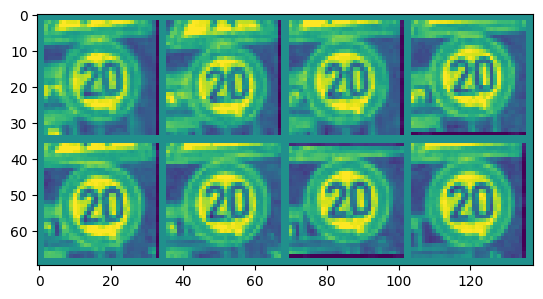

In [6]:
def get_train_images(num):
    return torch.stack([dataset[i][0] for i in range(10,10+num)], dim=0)

plt.imshow(torchvision.utils.make_grid(get_train_images(8), nrow=4)[0]);

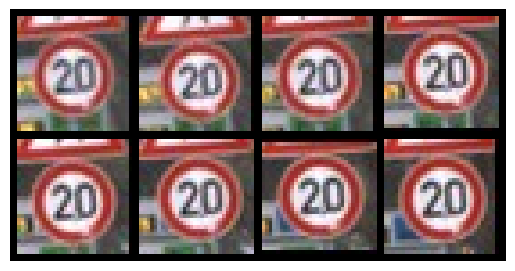

In [7]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def get_train_images(num):
    # Pobierz obrazy z datasetu
    images = torch.stack([dataset[i][0] for i in range(10, 10 + num)], dim=0)
    # Odwróć normalizację: (x * std) + mean
    images = images * 0.5 + 0.5  # dla mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
    return images

# Pobierz obrazy
images = get_train_images(8)

# Utwórz siatkę obrazów
grid = vutils.make_grid(images, nrow=4, padding=2, normalize=False)

# Zamień osie z (C, H, W) na (H, W, C) dla matplotlib
grid = grid.permute(1, 2, 0)

# Wyświetl obrazy
plt.imshow(grid)
plt.axis('off')
plt.show()

In [8]:
def corrupt(x, amount):
    noise = torch.randn_like(x)  # Gaussian noise
    amount = amount.view(-1, 1, 1, 1)
    # Blend original and noise, keeping range compatible with [-1, 1]
    noisy_x = x * (1 - amount) + noise * amount
    return noisy_x.clamp(-1, 1)  # Ensure output stays in [-1, 1]

Input shape: torch.Size([43, 3, 32, 32])


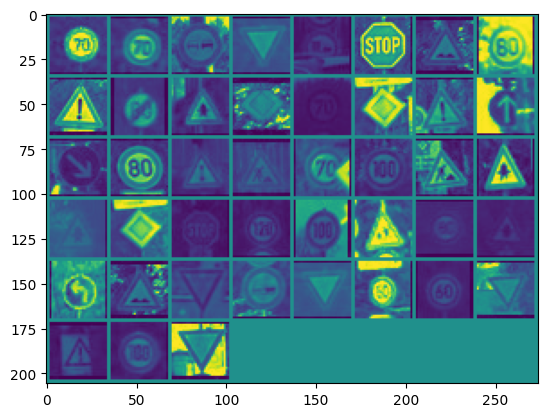

In [9]:
x, y = next(iter(loader))
x = x[:43]
print('Input shape:', x.shape)
plt.imshow(torchvision.utils.make_grid(x)[0]);

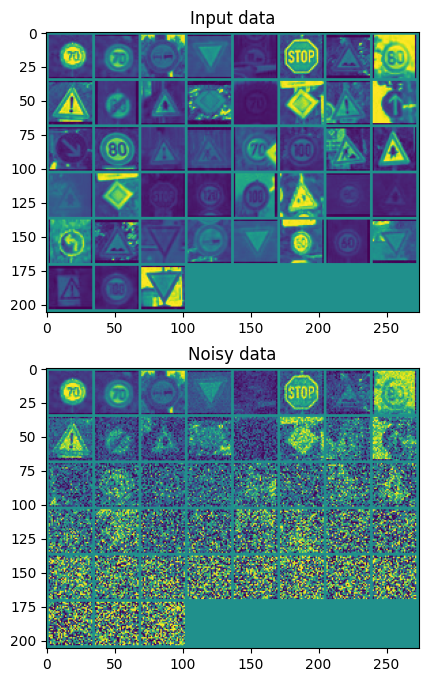

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0])

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

axs[1].set_title('Noisy data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0]);

In [12]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(128 + 2, 128, kernel_size=5, padding=2),
            nn.Conv2d(128, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x, y, t):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:
              h.append(x)
              x = self.downscale(x)
        t = t.repeat(1,x.size(2),x.size(3),1).permute(3,0,1,2)
        y = y.repeat(1,x.size(2),x.size(3),1).permute(3,0,1,2)
        x = torch.cat([x,t,y],dim=1)
        for i, l in enumerate(self.up_layers):
            if i > 1:
              x = self.upscale(x)
              x += h.pop()
            x = self.act(l(x))

        return x

In [ ]:
net = BasicUNet().to(device)
net

BasicUNet(
  (down_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (up_layers): ModuleList(
    (0): Conv2d(130, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (act): SiLU()
  (downscale): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upscale): Upsample(scale_factor=2.0, mode='nearest')
)

In [46]:
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, num_classes=43):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.batch_norm = nn.BatchNorm2d(out_ch)
        self.act = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch + 2, out_ch, 3, padding=1)
        nn.BatchNorm2d(out_ch)
        nn.ReLU()
        self.pool = nn.MaxPool2d(2)

    def forward(self, x, y, t):
        x = self.conv1(x)
        x = self.batch_norm(x)
        # print(f"{x.shape=}; {y.shape=}; {t.shape=}")
        y = y.repeat(1, x.size(2), x.size(3), 1).permute(3, 0, 1, 2)
        t = t.repeat(1, x.size(2), x.size(3), 1).permute(3, 0, 1, 2)
        # print(f"{x.shape=}; {y.shape=}; {t.shape=}")
        x = torch.cat([x, y, t], dim=1)
        x = self.act(x)
        x = self.conv2(x)
        x = self.batch_norm(x)
        x = self.act(x)
        return self.pool(x), x  # downsampled + skip

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch * 2 + 2, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def forward(self, x, skip, y, t):
        # print(f"{x.shape=}; {skip.shape=}")
        x = self.up(x)
        y = y.repeat(1, x.size(2), x.size(3), 1).permute(3, 0, 1, 2)
        t = t.repeat(1, x.size(2), x.size(3), 1).permute(3, 0, 1, 2)
        # print(f"after_up: {x.shape=}; {skip.shape=};")
        x = torch.cat([x, skip, y, t], dim=1)
        return self.conv(x)

class UNet32(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_ch=64, num_classes=43, emb_dim=64):
        super().__init__()
        self.down1 = DownBlock(in_channels, base_ch)
        self.down2 = DownBlock(base_ch, base_ch * 2)
        self.down3 = DownBlock(base_ch * 2, base_ch * 4)

        self.time_embed = nn.Linear(emb_dim, base_ch * 4)
        self.class_embed = nn.Embedding(num_classes, emb_dim)
        self.class_proj = nn.Linear(emb_dim, base_ch * 4)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_ch * 4, base_ch * 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(base_ch * 8, base_ch * 4, 3, padding=1),
            nn.ReLU(),
        )

        self.up3 = UpBlock(base_ch * 4, base_ch * 2)
        self.up2 = UpBlock(base_ch * 2, base_ch)
        self.up1 = UpBlock(base_ch * 1, base_ch)

        self.final = nn.Conv2d(base_ch, out_channels, kernel_size=1)

    def forward(self, x, t, y):
        d1, s1 = self.down1(x, y, t)
        d2, s2 = self.down2(d1, y, t)
        d3, s3 = self.down3(d2, y, t)

        b = self.bottleneck(d3)

        # if t_emb is not None:
        #     print(f"{b.shape=}")
        #     print(f"{t_emb.shape=}; {t_emb.dtype=}")
        #     t_proj = self.time_embed(t_emb).unsqueeze(-1).unsqueeze(-1)  # (B, C, 1, 1)
        #     # t_proj = t_emb.repeat(1,b.size(2),b.size(3),1).permute(3,0,1,2)
        #     print(f"{t_proj.shape=}")
        #     b = b + t_proj

        # if y is not None:
        #     print(f"{y.dtype=}; {x.dtype=}")
        #     y_emb = self.class_proj(self.class_embed(y).to(x.dtype)).unsqueeze(-1).unsqueeze(-1)
        #     # y_emb = self.class_proj
        #     b = b + y_emb

        u3 = self.up3(b, s3, y, t)
        u2 = self.up2(u3, s2, y, t)
        u1 = self.up1(u2, s1, y, t)
        # print(f"{u1.shape=}")

        return self.final(u1)


In [12]:
def tensor_to_image(tensor, normalize=True):
    tensor = tensor.cpu().detach()
    print(f"Tensor min: {tensor.min().item():.4f}, max: {tensor.max().item():.4f}")
    if normalize:
        tensor = (tensor + 1) / 2
        tensor = tensor.clamp(0, 1)
    tensor = tensor.permute(1, 2, 0)
    return tensor.numpy()

100%|██████████| 613/613 [00:42<00:00, 14.55it/s]


Finished epoch 0. Average loss for this epoch: 0.030222
Sample 1:
Tensor min: -1.0000, max: 0.8588
Tensor min: -1.0000, max: 0.9439
Tensor min: -1.0987, max: 0.9435
Sample 2:
Tensor min: -1.0000, max: -0.3490
Tensor min: -1.0000, max: 0.0474
Tensor min: -1.0896, max: -0.4687
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.1709, max: 1.0732


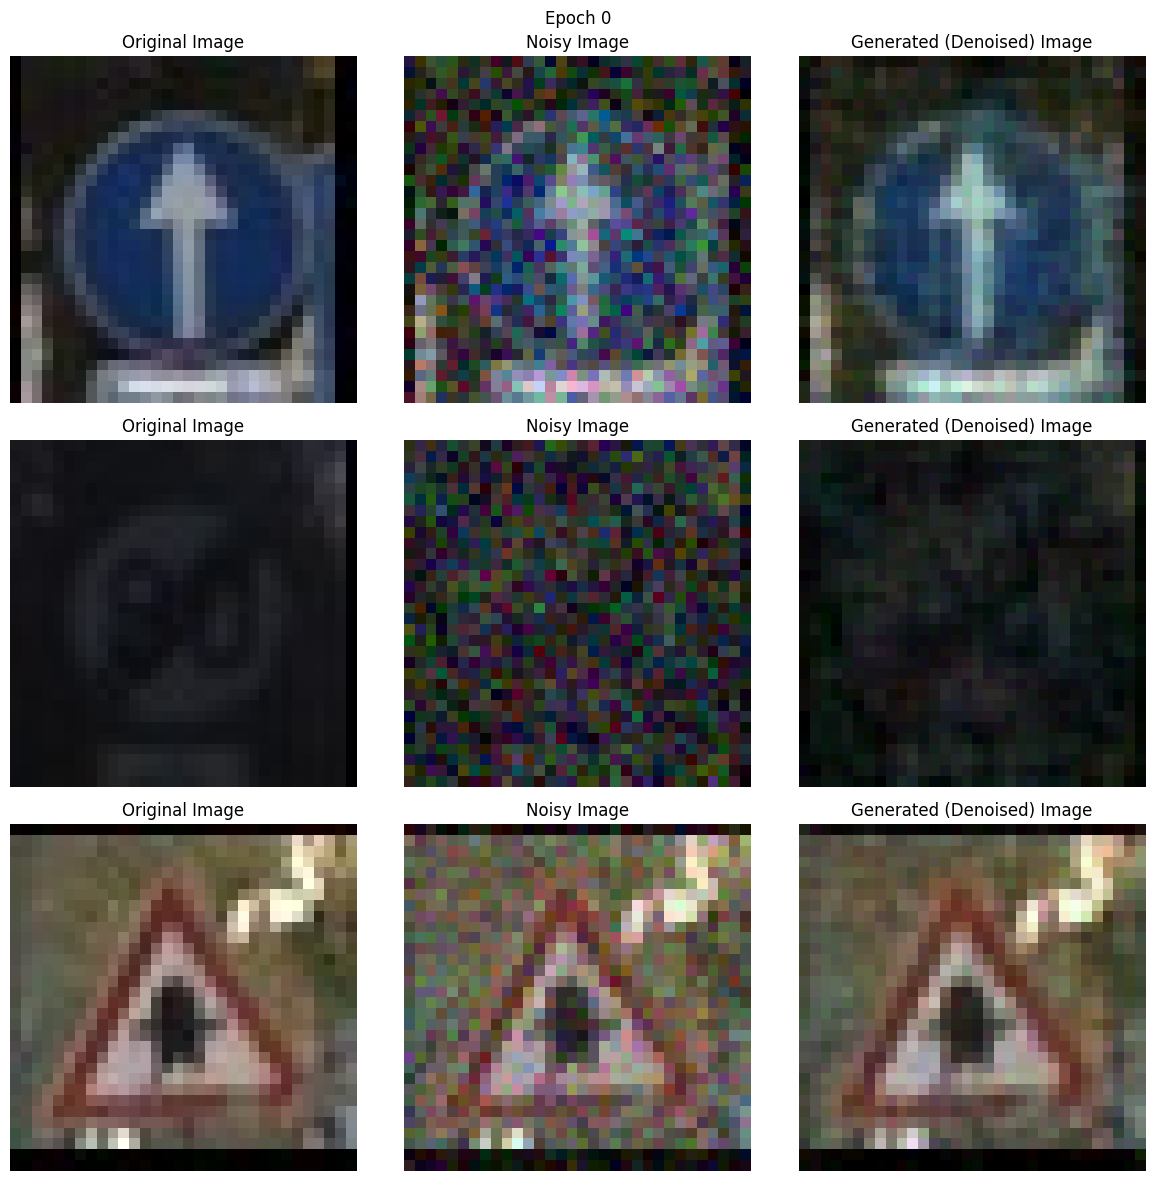

100%|██████████| 613/613 [00:41<00:00, 14.80it/s]


Finished epoch 1. Average loss for this epoch: 0.008692
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.2234, max: 1.0838
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0568, max: 1.2941
Sample 3:
Tensor min: -1.0000, max: -0.3098
Tensor min: -1.0000, max: 0.1355
Tensor min: -1.0552, max: -0.0908


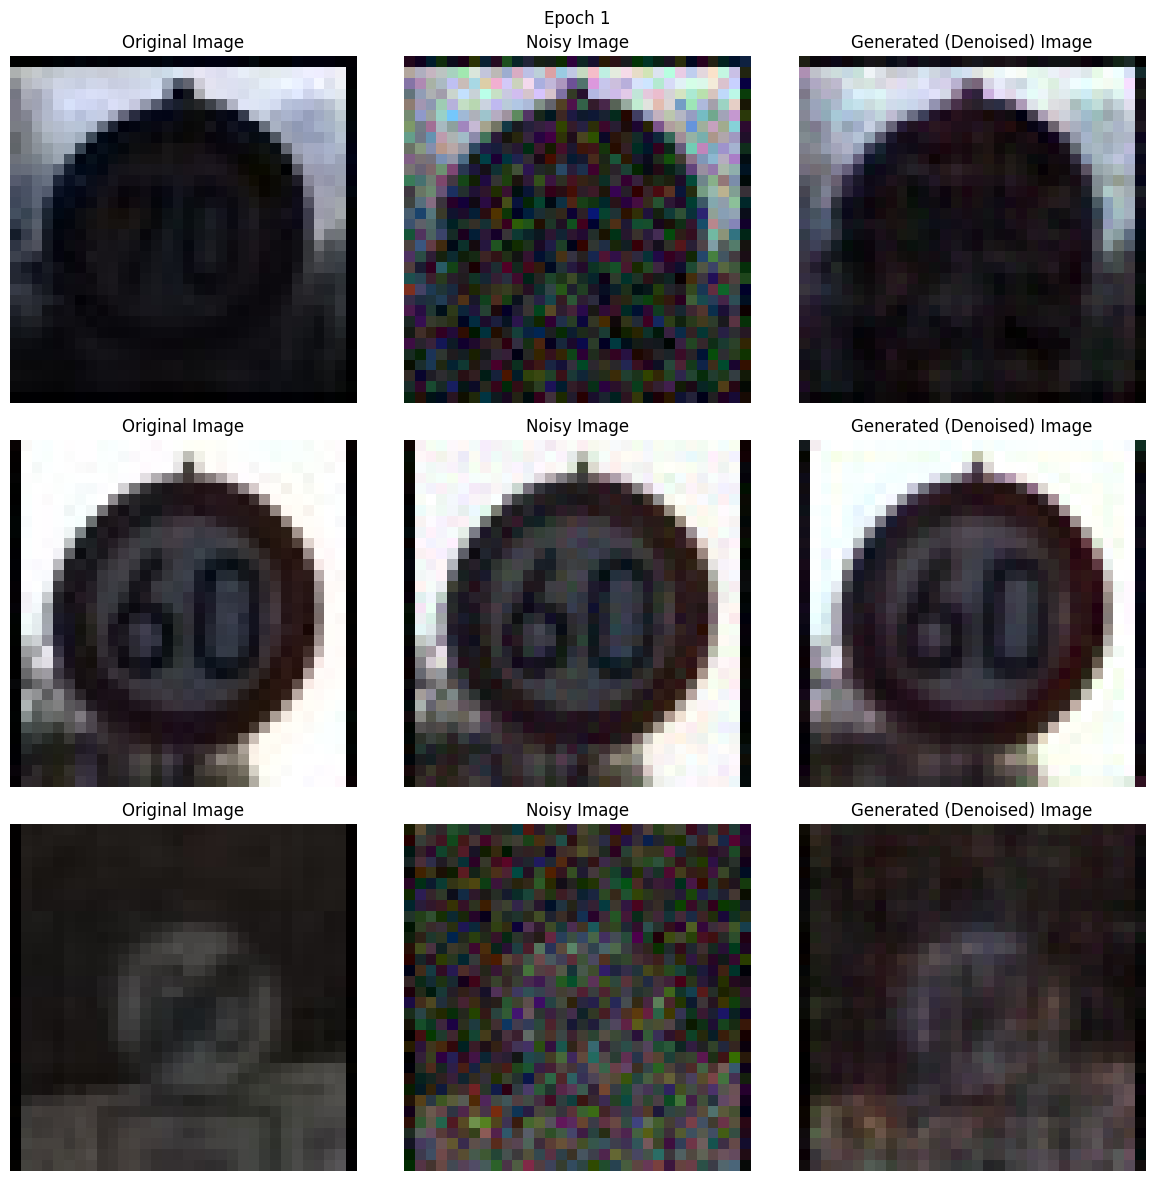

100%|██████████| 613/613 [00:42<00:00, 14.51it/s]


Finished epoch 2. Average loss for this epoch: 0.007359
Sample 1:
Tensor min: -1.0000, max: -0.1922
Tensor min: -1.0000, max: -0.0801
Tensor min: -1.1228, max: -0.1322
Sample 2:
Tensor min: -1.0000, max: 0.5922
Tensor min: -1.0000, max: 0.5083
Tensor min: -1.1209, max: 0.3463
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.1706, max: 1.3018


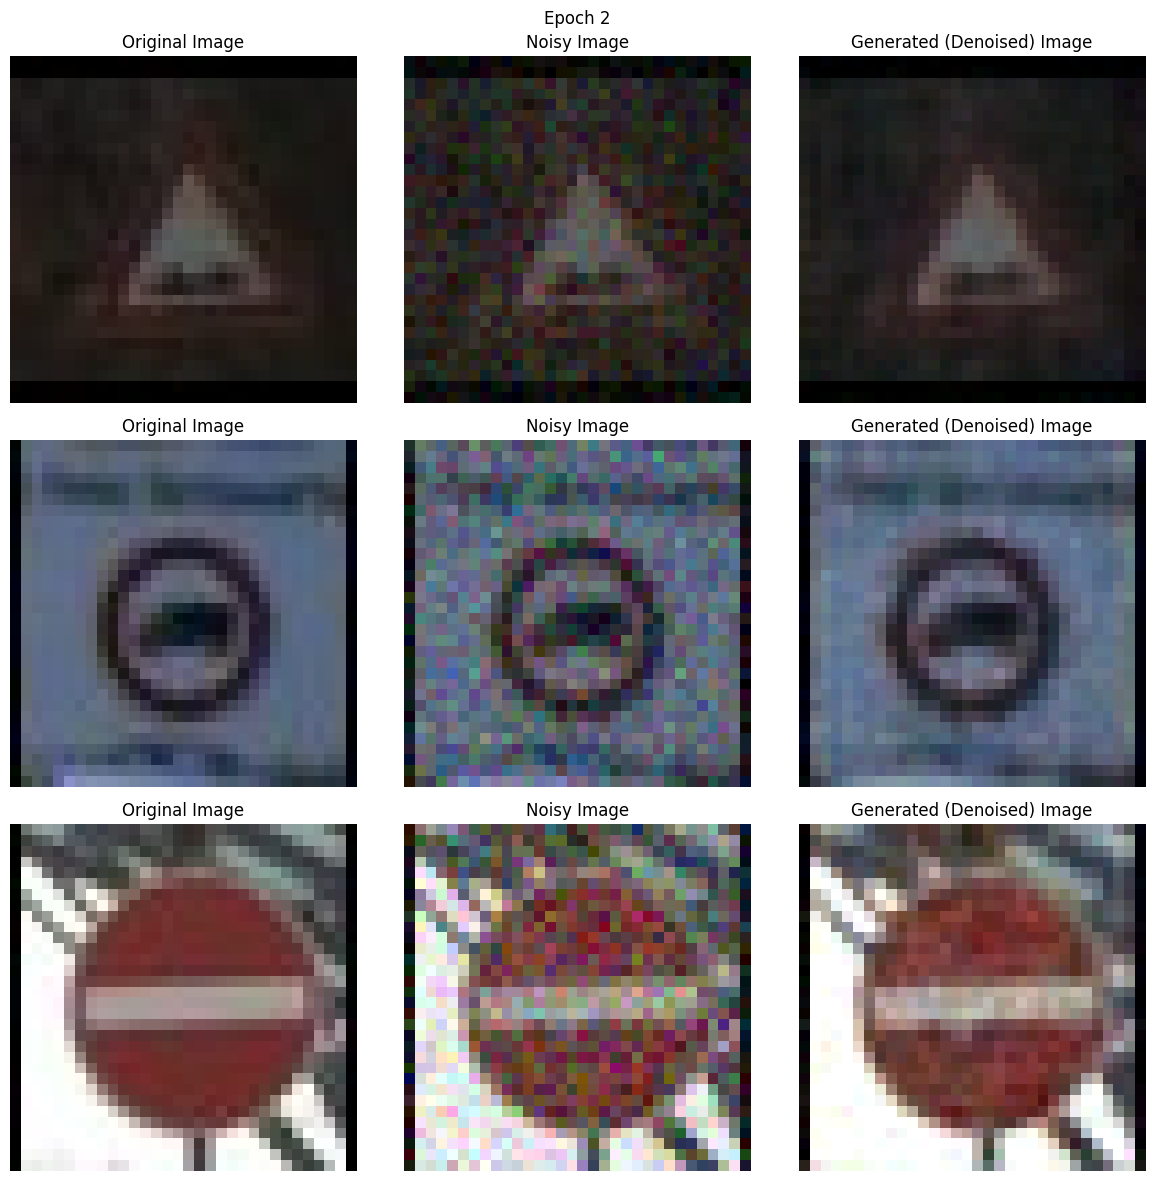

100%|██████████| 613/613 [00:42<00:00, 14.52it/s]


Finished epoch 3. Average loss for this epoch: 0.006562
Sample 1:
Tensor min: -1.0000, max: 0.9294
Tensor min: -1.0000, max: 0.8934
Tensor min: -1.0466, max: 0.8722
Sample 2:
Tensor min: -1.0000, max: 0.3804
Tensor min: -1.0000, max: 0.5048
Tensor min: -1.0652, max: 0.3344
Sample 3:
Tensor min: -1.0000, max: -0.3176
Tensor min: -1.0000, max: -0.1380
Tensor min: -1.0886, max: -0.3343


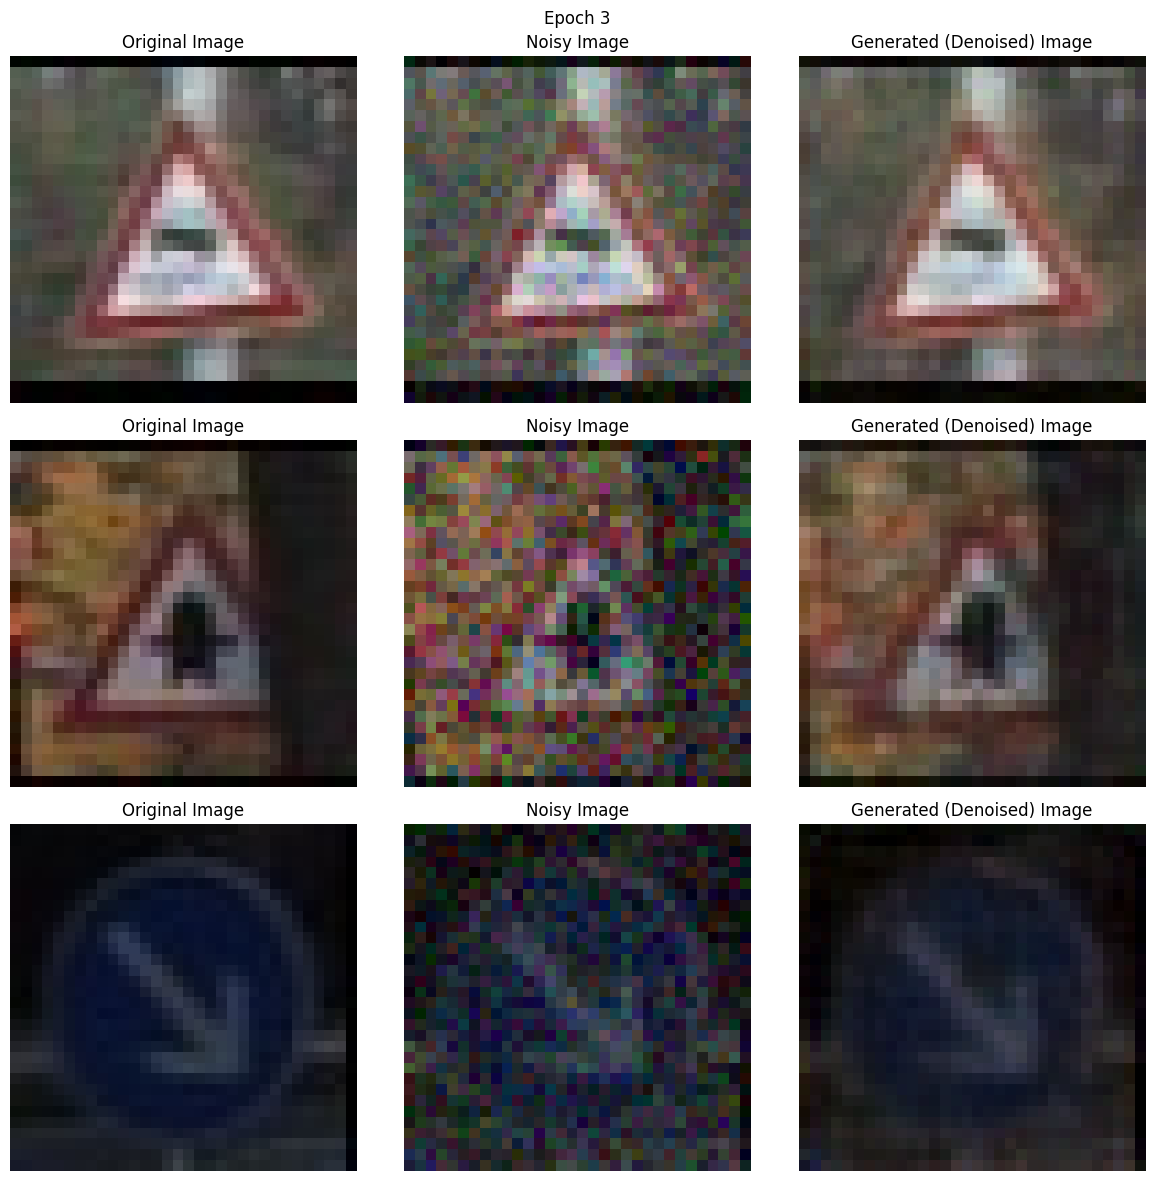

100%|██████████| 613/613 [00:42<00:00, 14.27it/s]


Finished epoch 4. Average loss for this epoch: 0.005802
Sample 1:
Tensor min: -0.9922, max: 0.1294
Tensor min: -0.9907, max: 0.1295
Tensor min: -0.9691, max: -0.0522
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.1225, max: 1.0357
Sample 3:
Tensor min: -0.9451, max: 0.0588
Tensor min: -1.0000, max: 0.2066
Tensor min: -0.8653, max: 0.1250


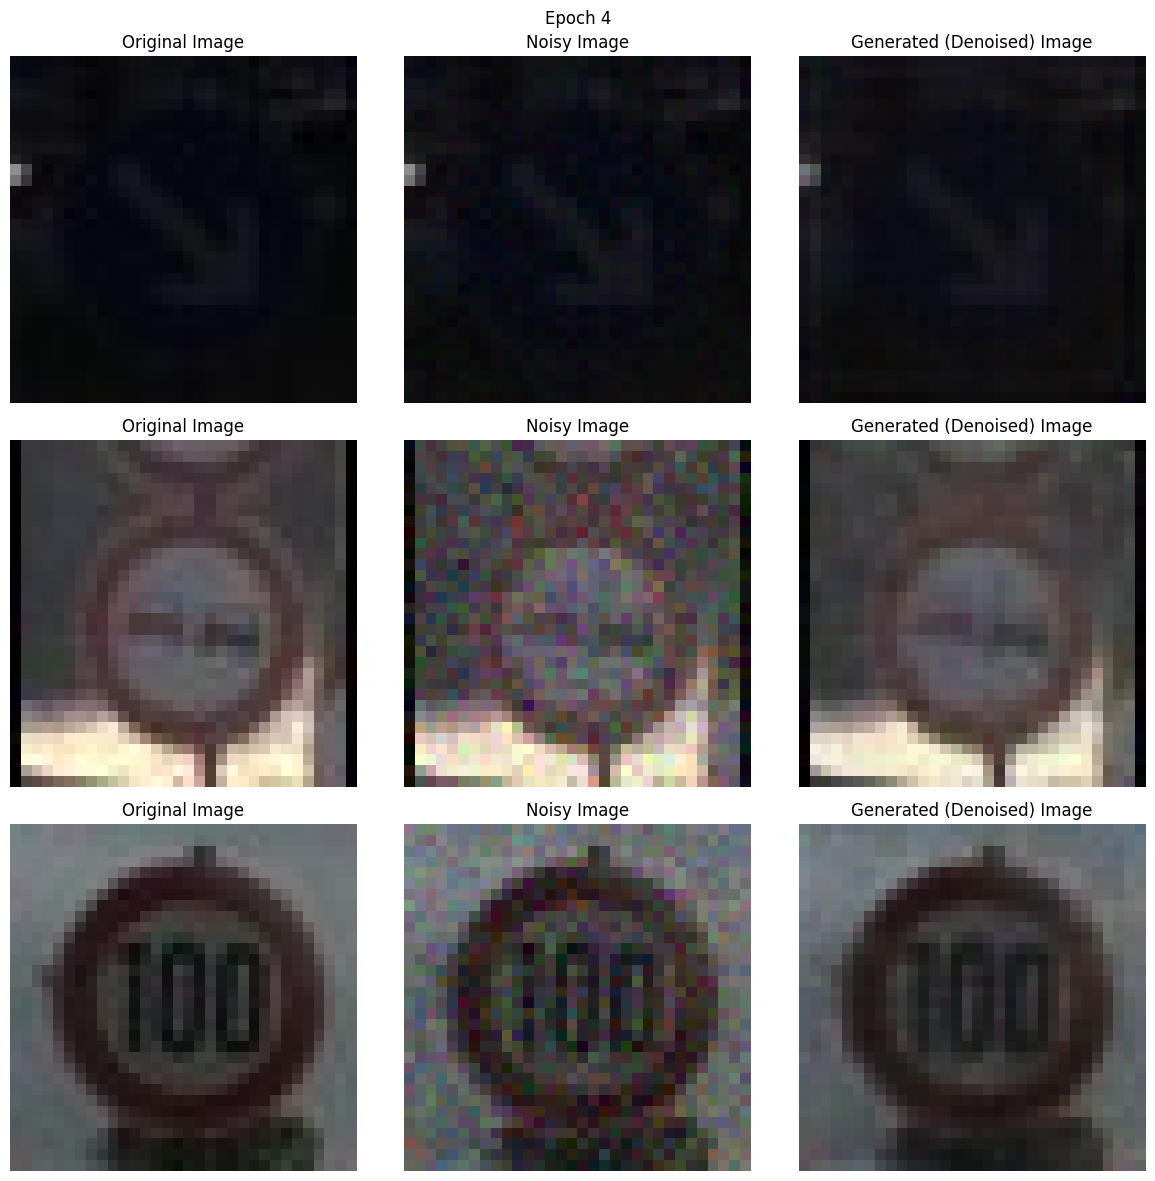

100%|██████████| 613/613 [00:42<00:00, 14.31it/s]


Finished epoch 5. Average loss for this epoch: 0.005004
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.1093, max: 1.1001
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0416, max: 1.1518
Sample 3:
Tensor min: -0.9451, max: 0.1059
Tensor min: -0.9291, max: 0.1176
Tensor min: -1.0362, max: 0.0254


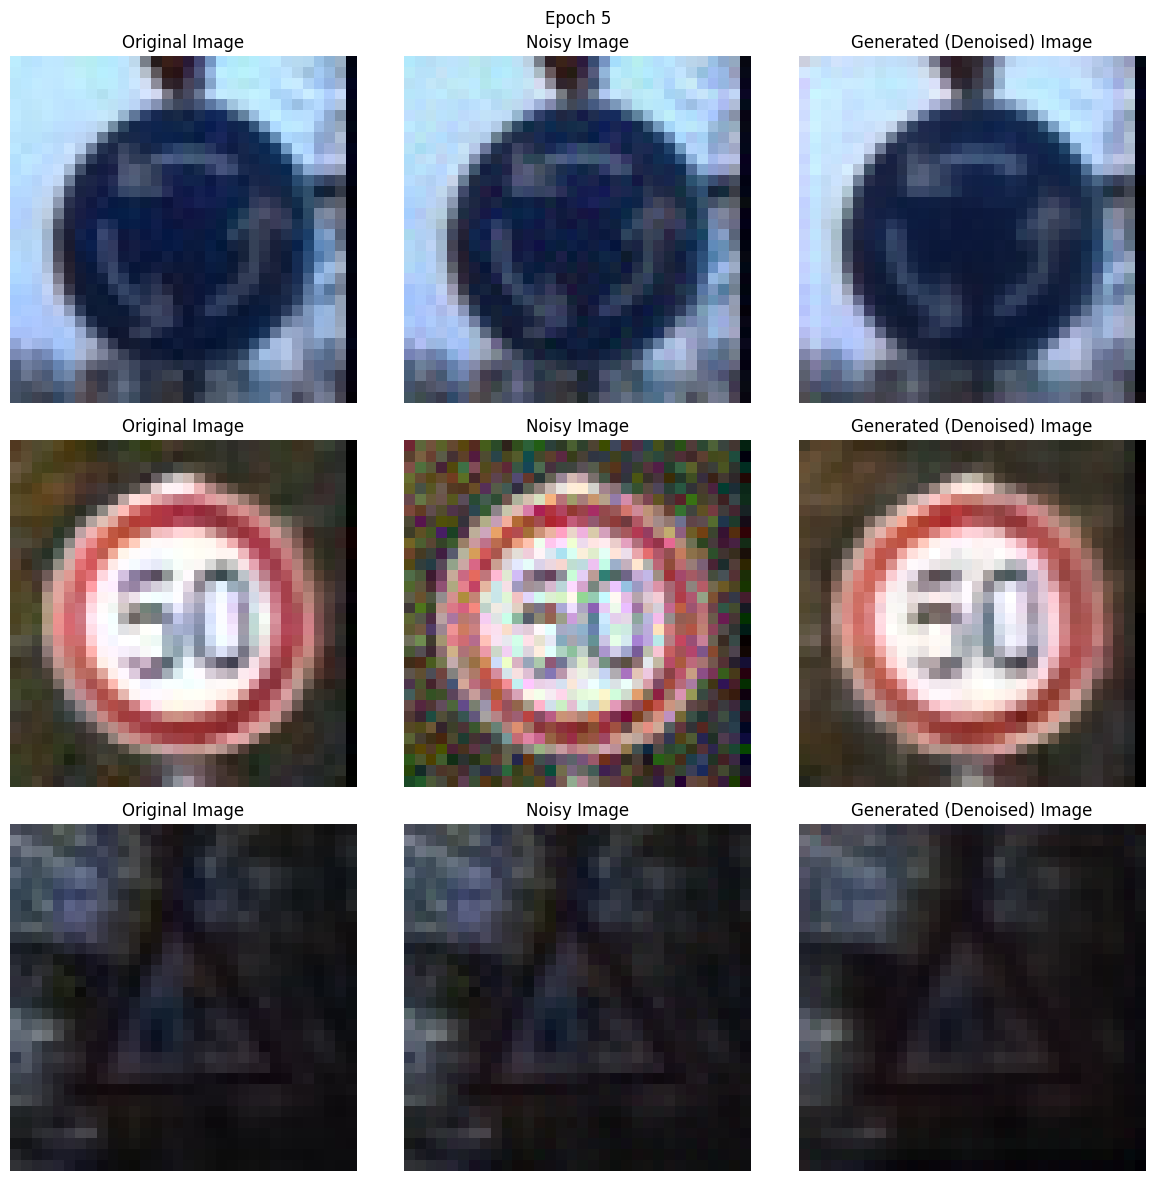

100%|██████████| 613/613 [00:43<00:00, 14.25it/s]


Finished epoch 6. Average loss for this epoch: 0.004713
Sample 1:
Tensor min: -0.9529, max: -0.6314
Tensor min: -0.9663, max: -0.5825
Tensor min: -0.9524, max: -0.6240
Sample 2:
Tensor min: -1.0000, max: 0.5059
Tensor min: -1.0000, max: 0.8271
Tensor min: -1.0549, max: 0.5428
Sample 3:
Tensor min: -0.9216, max: -0.1529
Tensor min: -1.0000, max: 0.2712
Tensor min: -0.9326, max: -0.0322


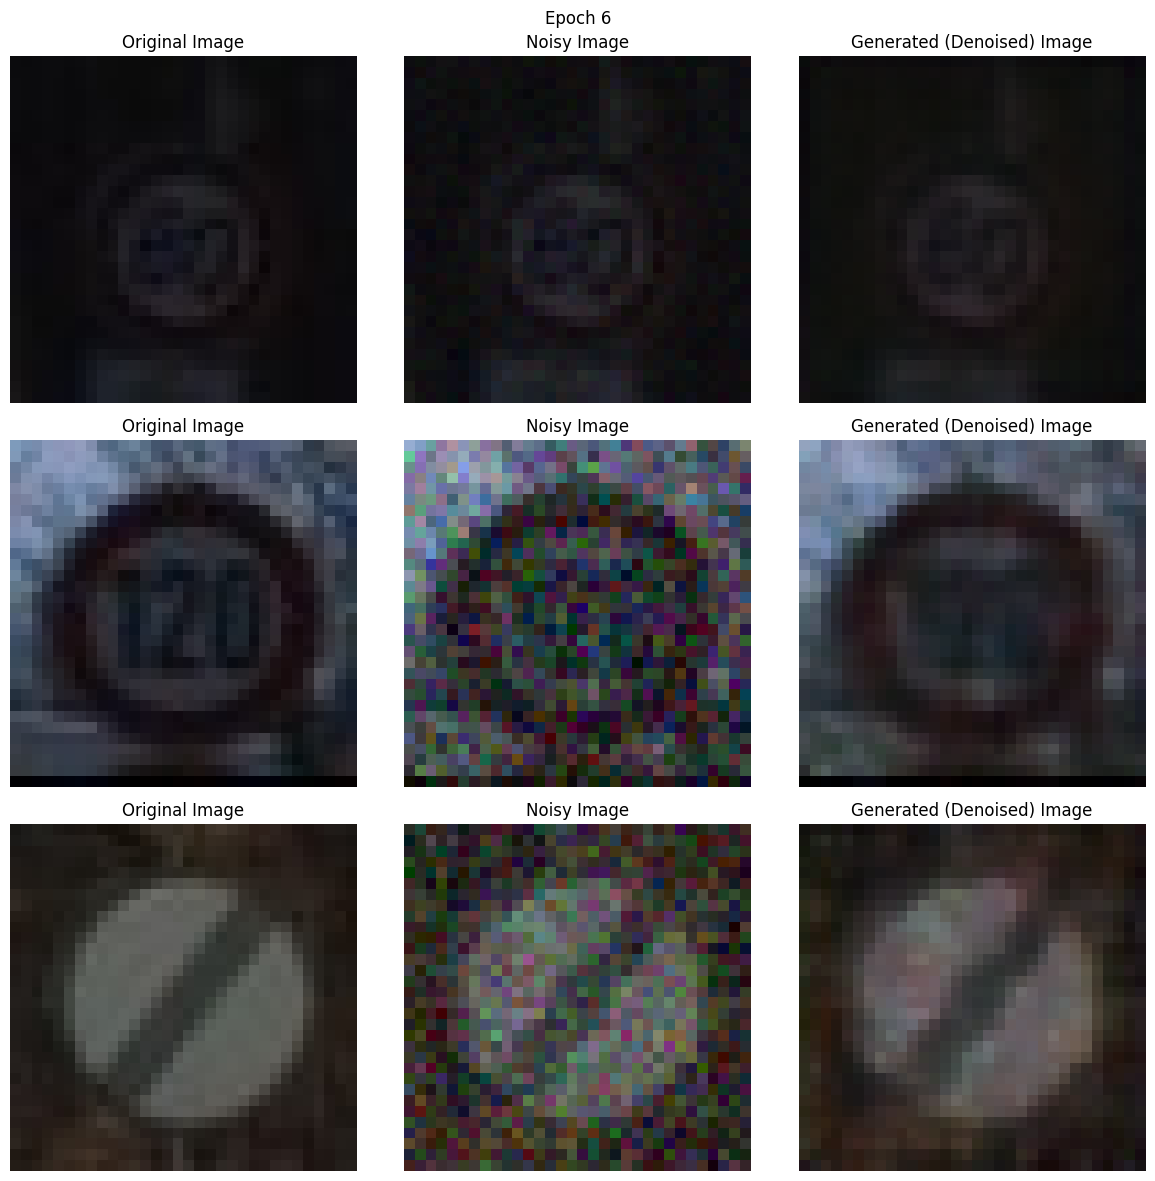

100%|██████████| 613/613 [00:42<00:00, 14.39it/s]


Finished epoch 7. Average loss for this epoch: 0.004441
Sample 1:
Tensor min: -1.0000, max: 0.9529
Tensor min: -1.0000, max: 0.9514
Tensor min: -1.1025, max: 0.9834
Sample 2:
Tensor min: -1.0000, max: -0.3882
Tensor min: -1.0000, max: 0.0113
Tensor min: -1.0459, max: -0.3262
Sample 3:
Tensor min: -0.9059, max: 0.3725
Tensor min: -1.0000, max: 0.5137
Tensor min: -0.8958, max: 0.3955


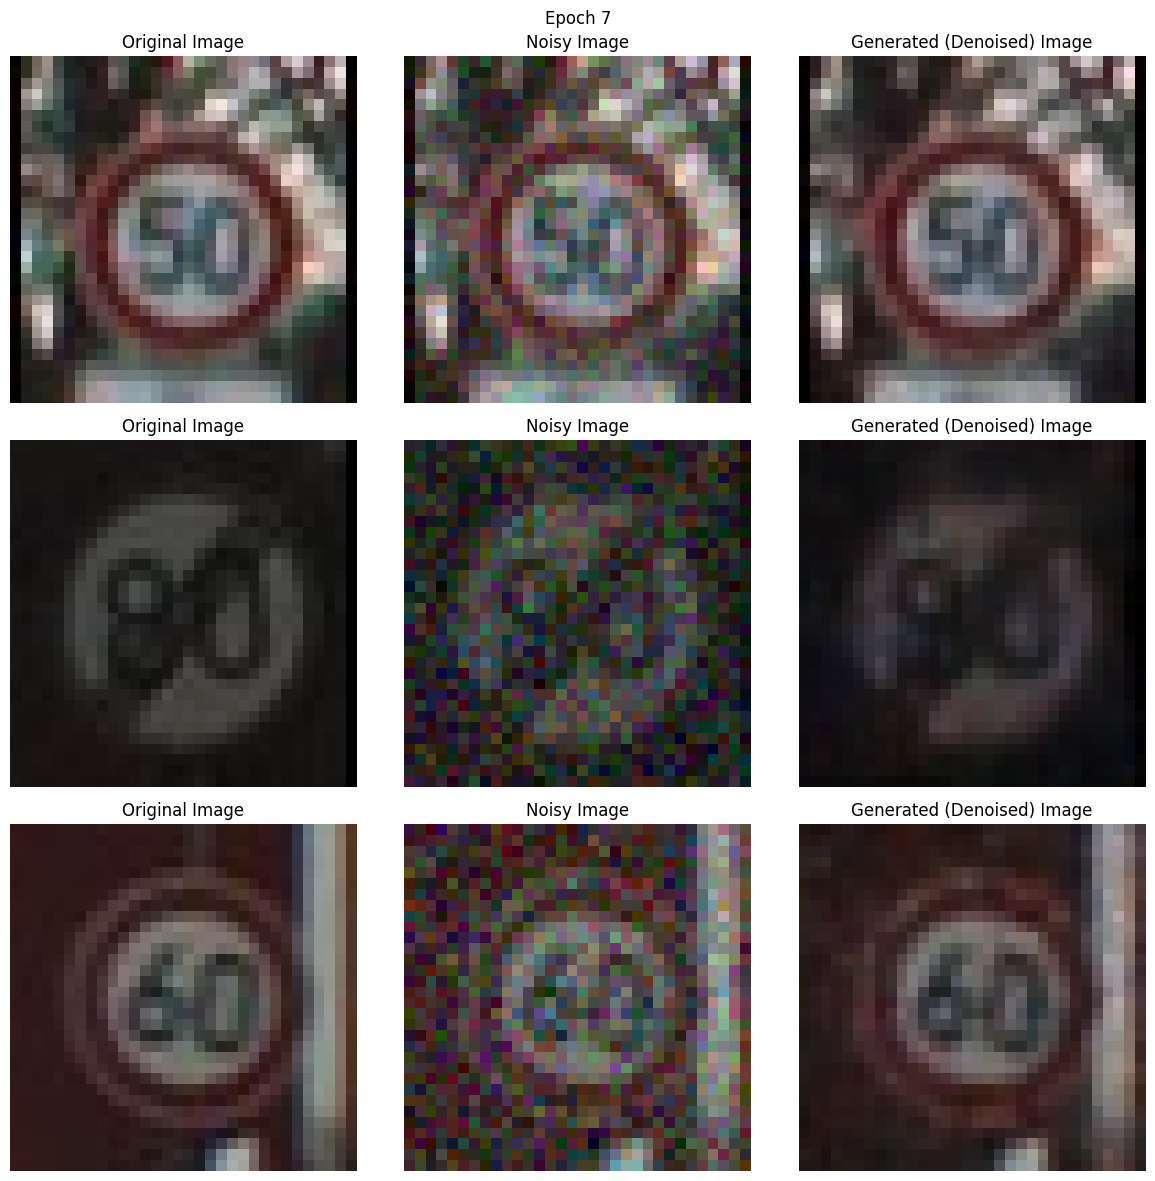

100%|██████████| 613/613 [00:42<00:00, 14.37it/s]


Finished epoch 8. Average loss for this epoch: 0.004177
Sample 1:
Tensor min: -1.0000, max: 0.5373
Tensor min: -1.0000, max: 0.7406
Tensor min: -1.1335, max: 0.5590
Sample 2:
Tensor min: -0.9686, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.9380, max: 1.0856
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.1051, max: 1.1305


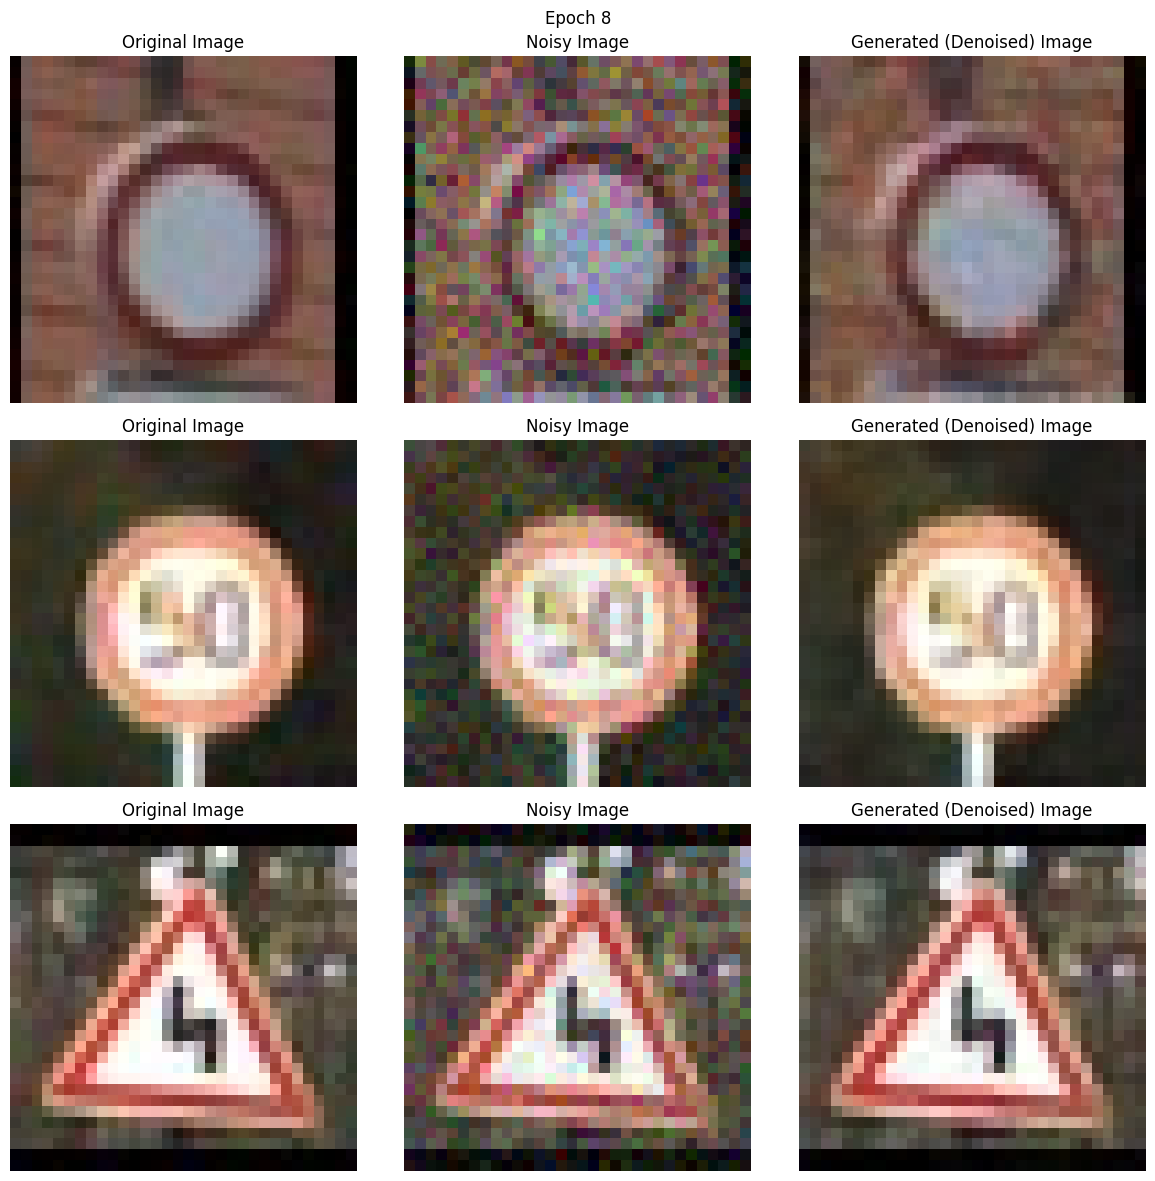

100%|██████████| 613/613 [00:42<00:00, 14.26it/s]


Finished epoch 9. Average loss for this epoch: 0.003969
Sample 1:
Tensor min: -1.0000, max: -0.5059
Tensor min: -1.0000, max: -0.1087
Tensor min: -1.1023, max: -0.4316
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0228, max: 1.1456
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0291, max: 0.9833


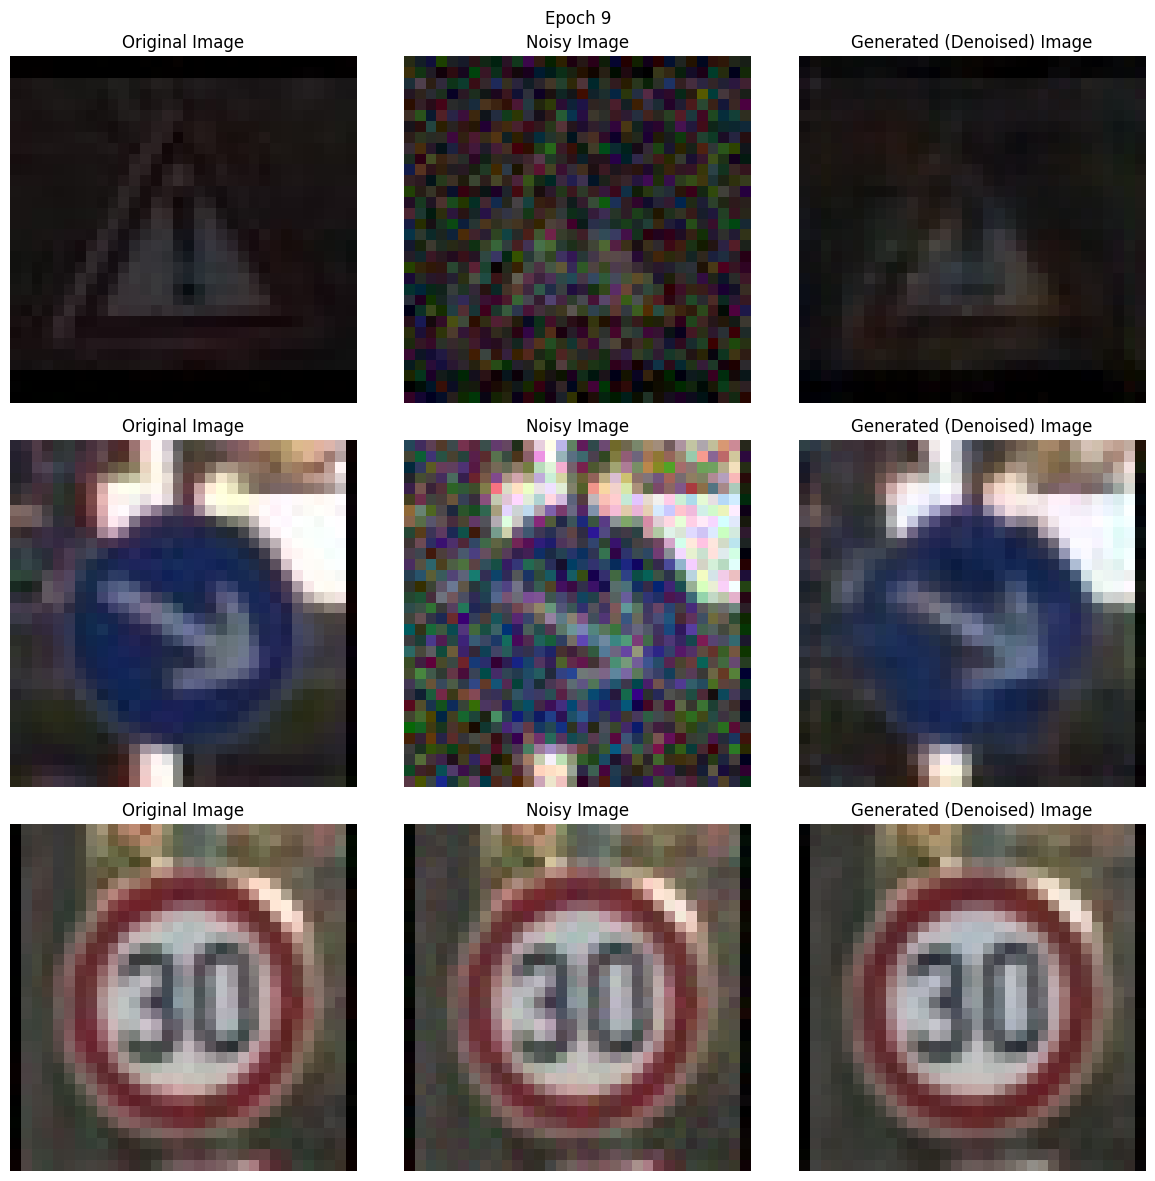

100%|██████████| 613/613 [00:43<00:00, 14.10it/s]


Finished epoch 10. Average loss for this epoch: 0.003817
Sample 1:
Tensor min: -0.9765, max: 0.8275
Tensor min: -1.0000, max: 0.8665
Tensor min: -0.9298, max: 0.9219
Sample 2:
Tensor min: -0.9294, max: 1.0000
Tensor min: -0.9286, max: 1.0000
Tensor min: -0.9823, max: 1.0532
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.1134, max: 1.1683


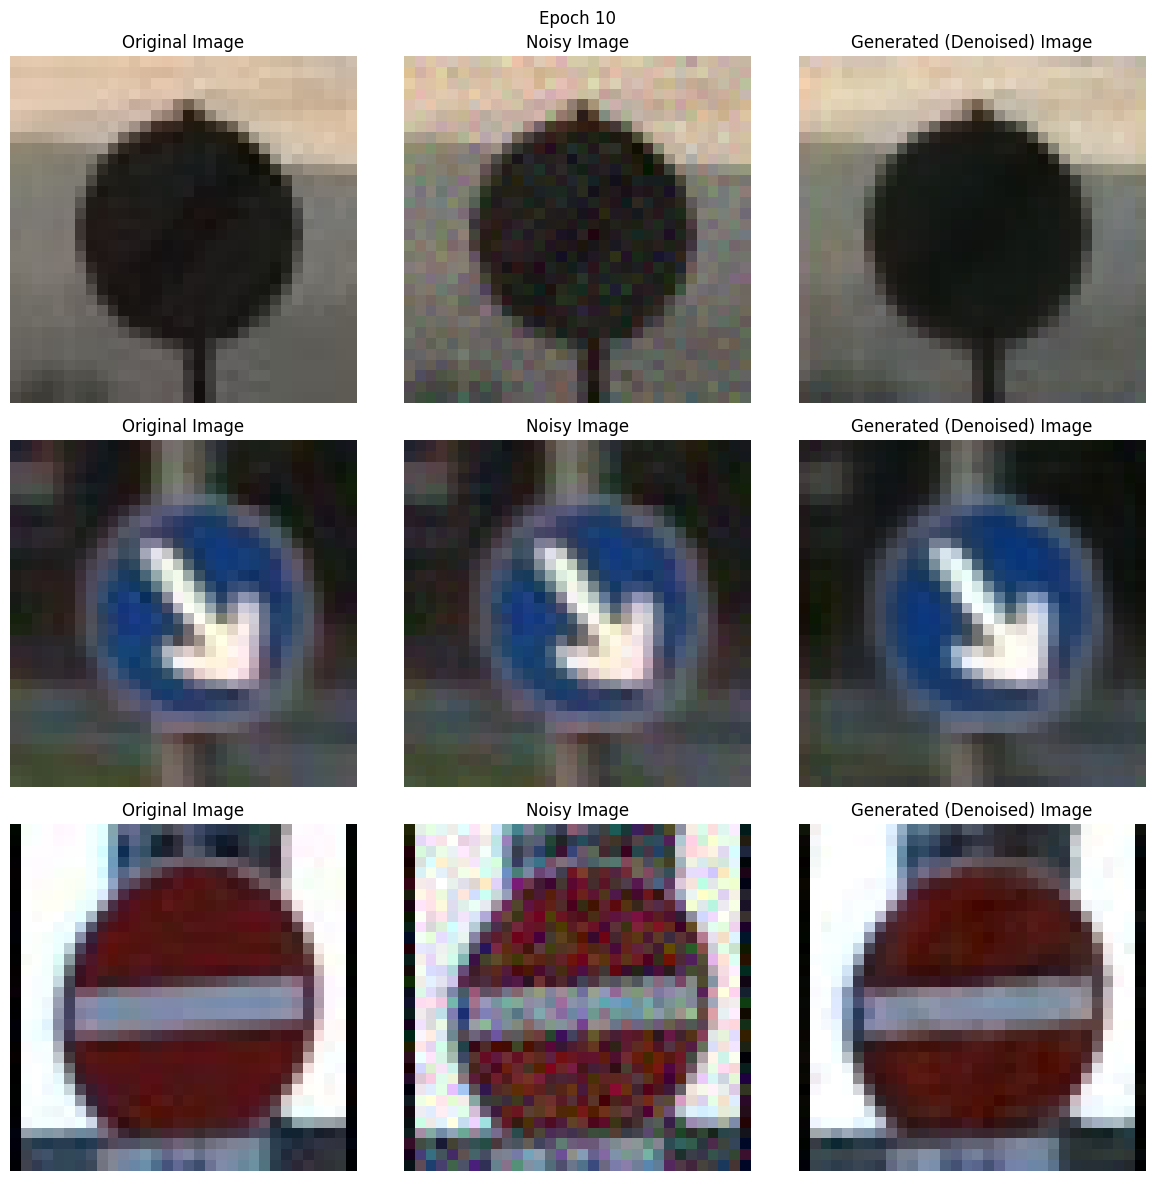

100%|██████████| 613/613 [00:43<00:00, 14.16it/s]


Finished epoch 11. Average loss for this epoch: 0.003674
Sample 1:
Tensor min: -1.0000, max: 0.8745
Tensor min: -1.0000, max: 0.7028
Tensor min: -1.1041, max: 0.6900
Sample 2:
Tensor min: -1.0000, max: 0.6627
Tensor min: -1.0000, max: 0.5123
Tensor min: -1.0552, max: 0.4721
Sample 3:
Tensor min: -1.0000, max: -0.5608
Tensor min: -1.0000, max: -0.4517
Tensor min: -1.0780, max: -0.5451


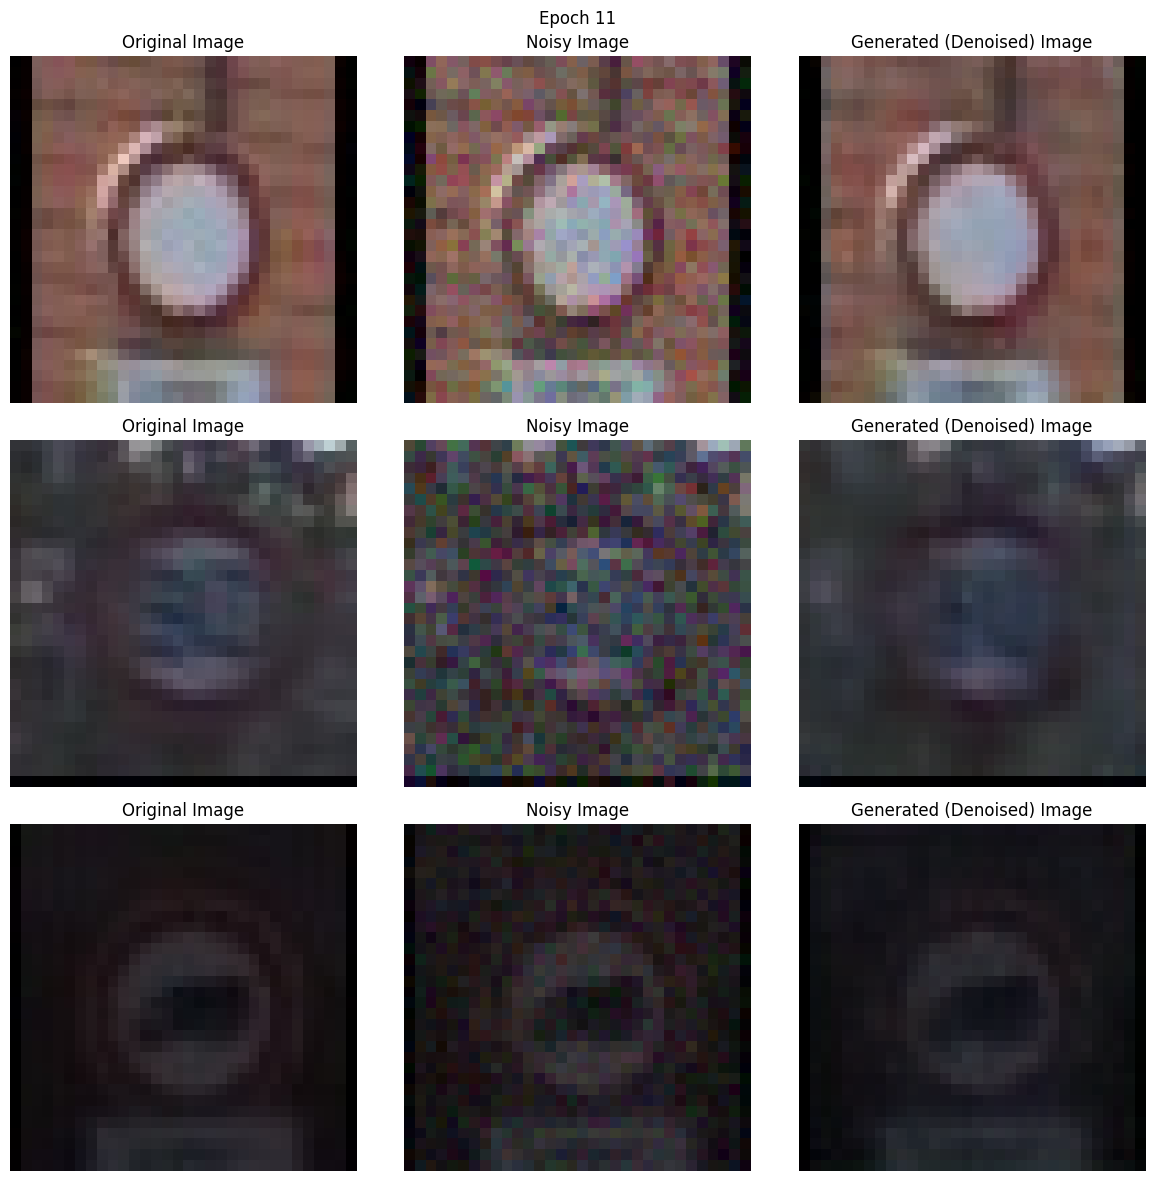

100%|██████████| 613/613 [00:43<00:00, 14.14it/s]


Finished epoch 12. Average loss for this epoch: 0.003657
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.1117, max: 1.1170
Sample 2:
Tensor min: -1.0000, max: -0.3804
Tensor min: -1.0000, max: 0.0171
Tensor min: -1.0240, max: -0.4042
Sample 3:
Tensor min: -1.0000, max: 0.2549
Tensor min: -1.0000, max: 0.3919
Tensor min: -1.0416, max: 0.0807


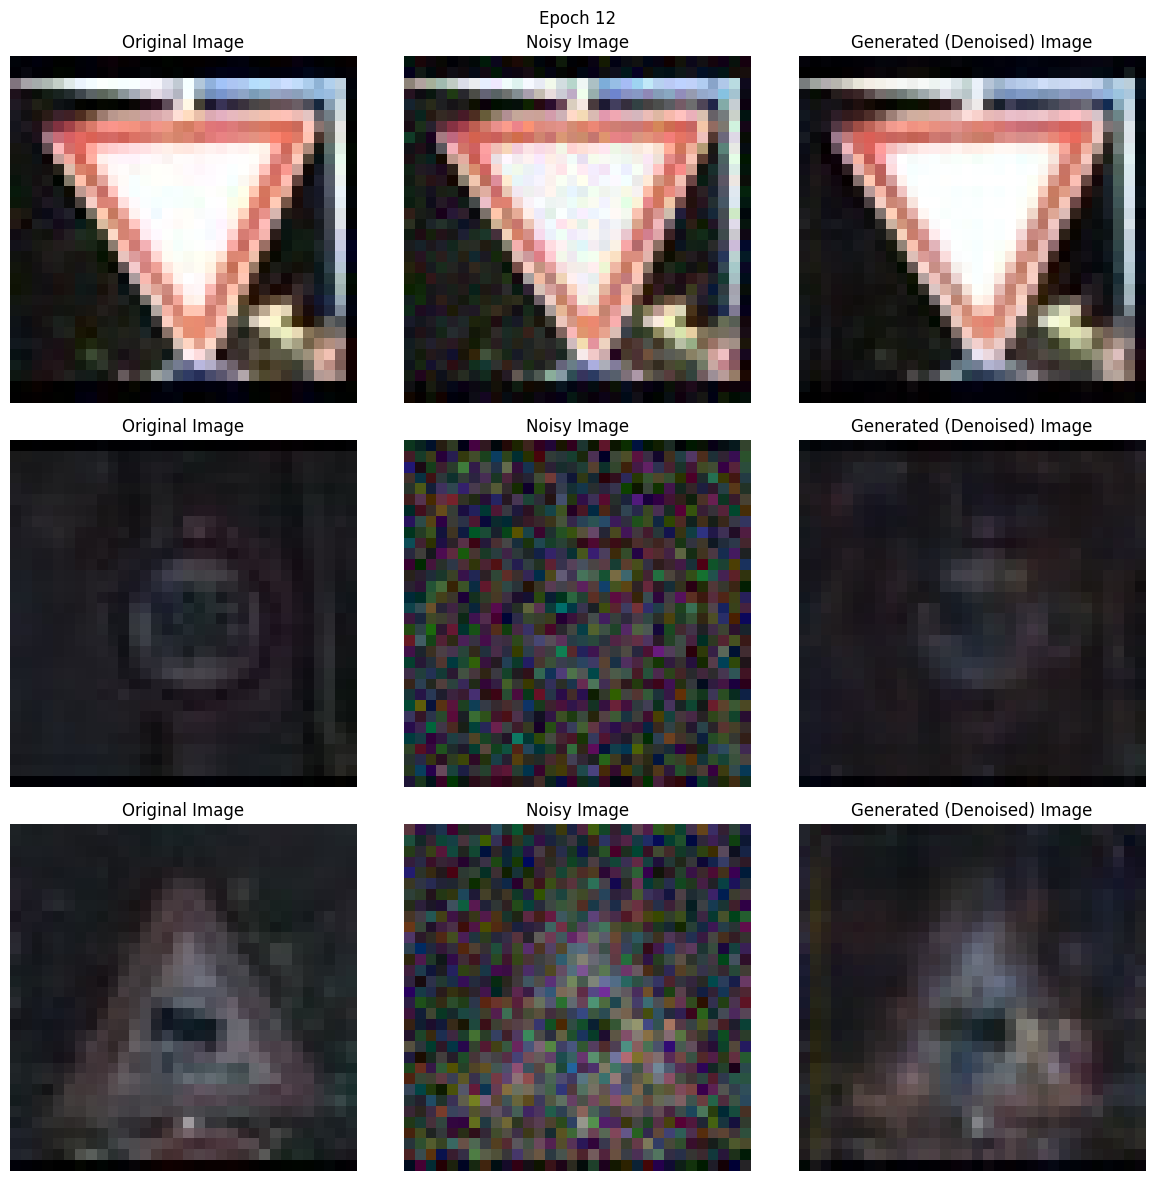

100%|██████████| 613/613 [00:44<00:00, 13.81it/s]


Finished epoch 13. Average loss for this epoch: 0.003472
Sample 1:
Tensor min: -1.0000, max: 0.0667
Tensor min: -1.0000, max: 0.2444
Tensor min: -1.0917, max: -0.0326
Sample 2:
Tensor min: -0.8745, max: 0.9373
Tensor min: -1.0000, max: 0.8818
Tensor min: -0.8679, max: 0.8712
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0874, max: 1.0976


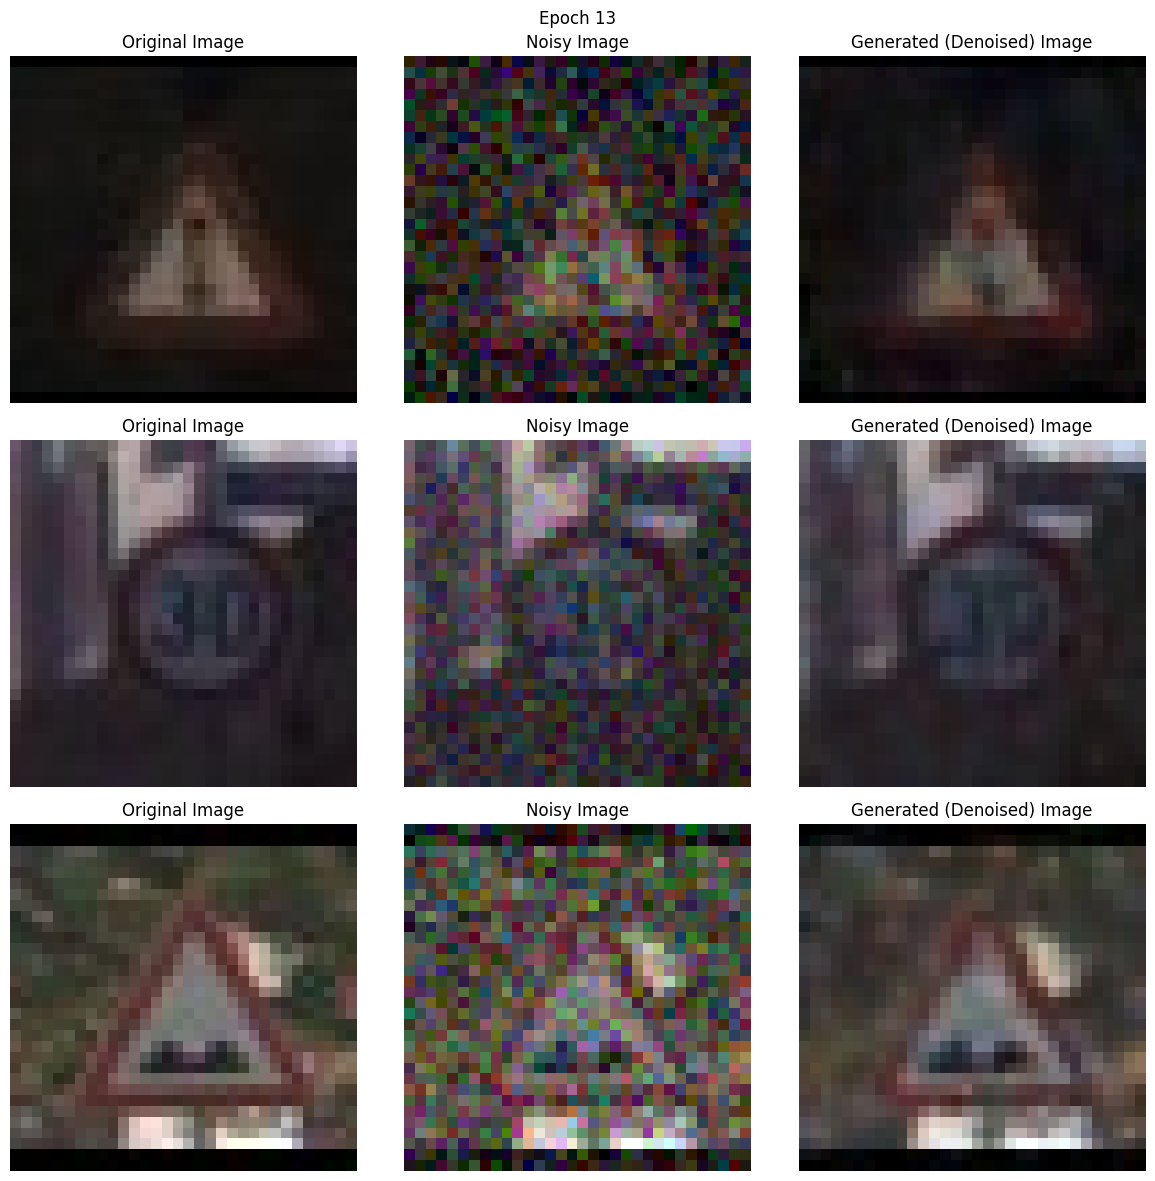

100%|██████████| 613/613 [00:43<00:00, 14.11it/s]


Finished epoch 14. Average loss for this epoch: 0.003445
Sample 1:
Tensor min: -1.0000, max: 0.5765
Tensor min: -1.0000, max: 0.5793
Tensor min: -1.0082, max: 0.6052
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0844, max: 1.1109
Sample 3:
Tensor min: -1.0000, max: 0.4431
Tensor min: -1.0000, max: 0.5641
Tensor min: -1.0268, max: 0.4708


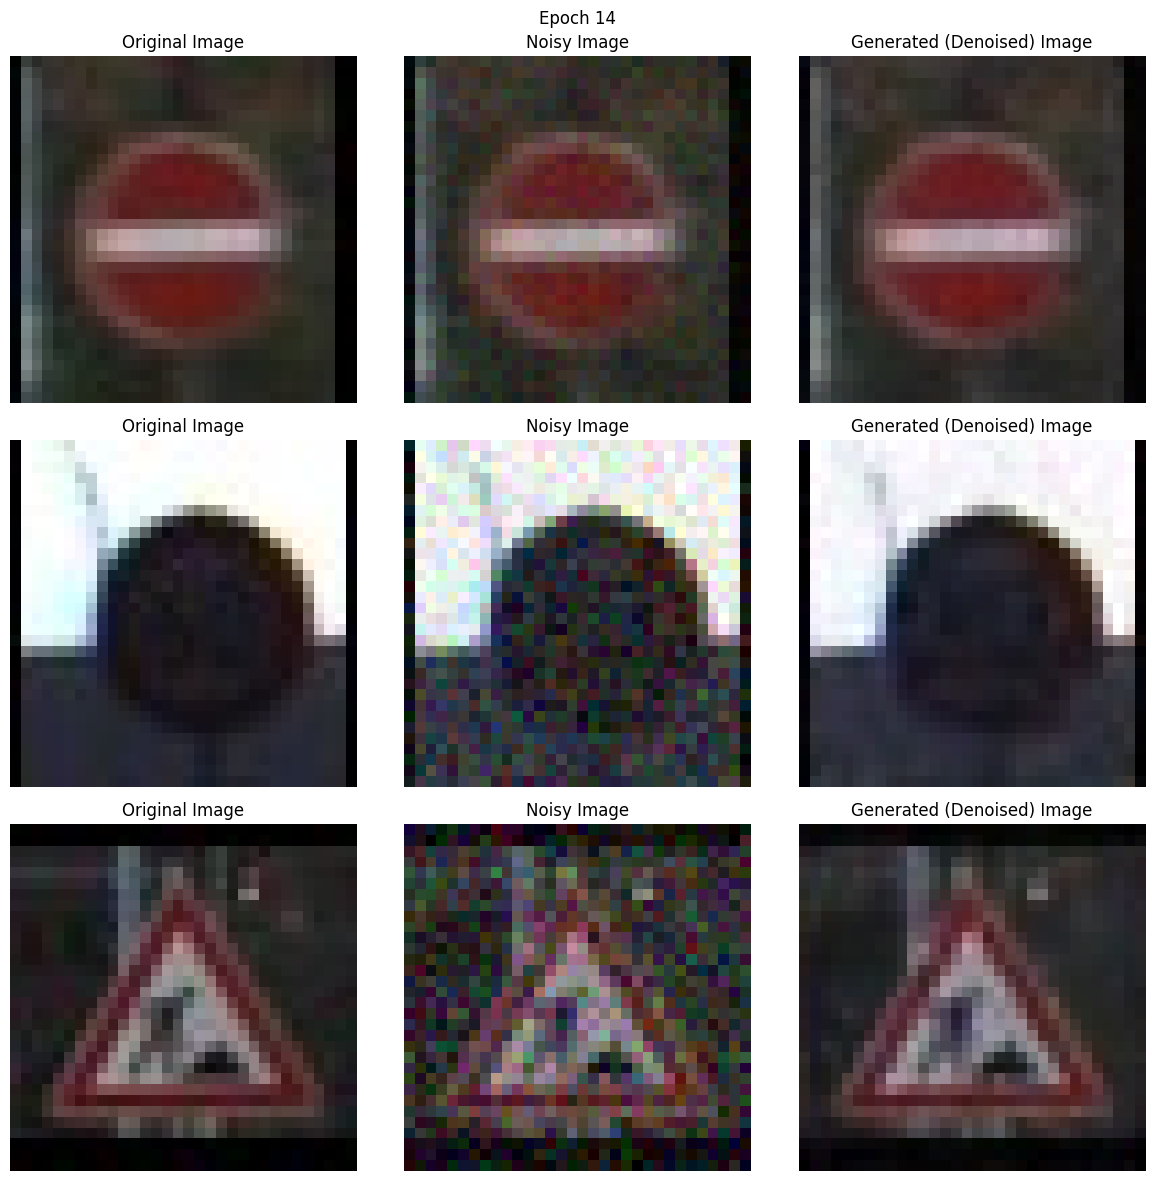

100%|██████████| 613/613 [00:44<00:00, 13.72it/s]


Finished epoch 15. Average loss for this epoch: 0.003335
Sample 1:
Tensor min: -0.9765, max: -0.8353
Tensor min: -1.0000, max: -0.0827
Tensor min: -1.0068, max: -0.8006
Sample 2:
Tensor min: -1.0000, max: 0.8667
Tensor min: -1.0000, max: 0.9925
Tensor min: -1.0833, max: 0.7626
Sample 3:
Tensor min: -1.0000, max: 0.9216
Tensor min: -1.0000, max: 0.9379
Tensor min: -1.0160, max: 0.8324


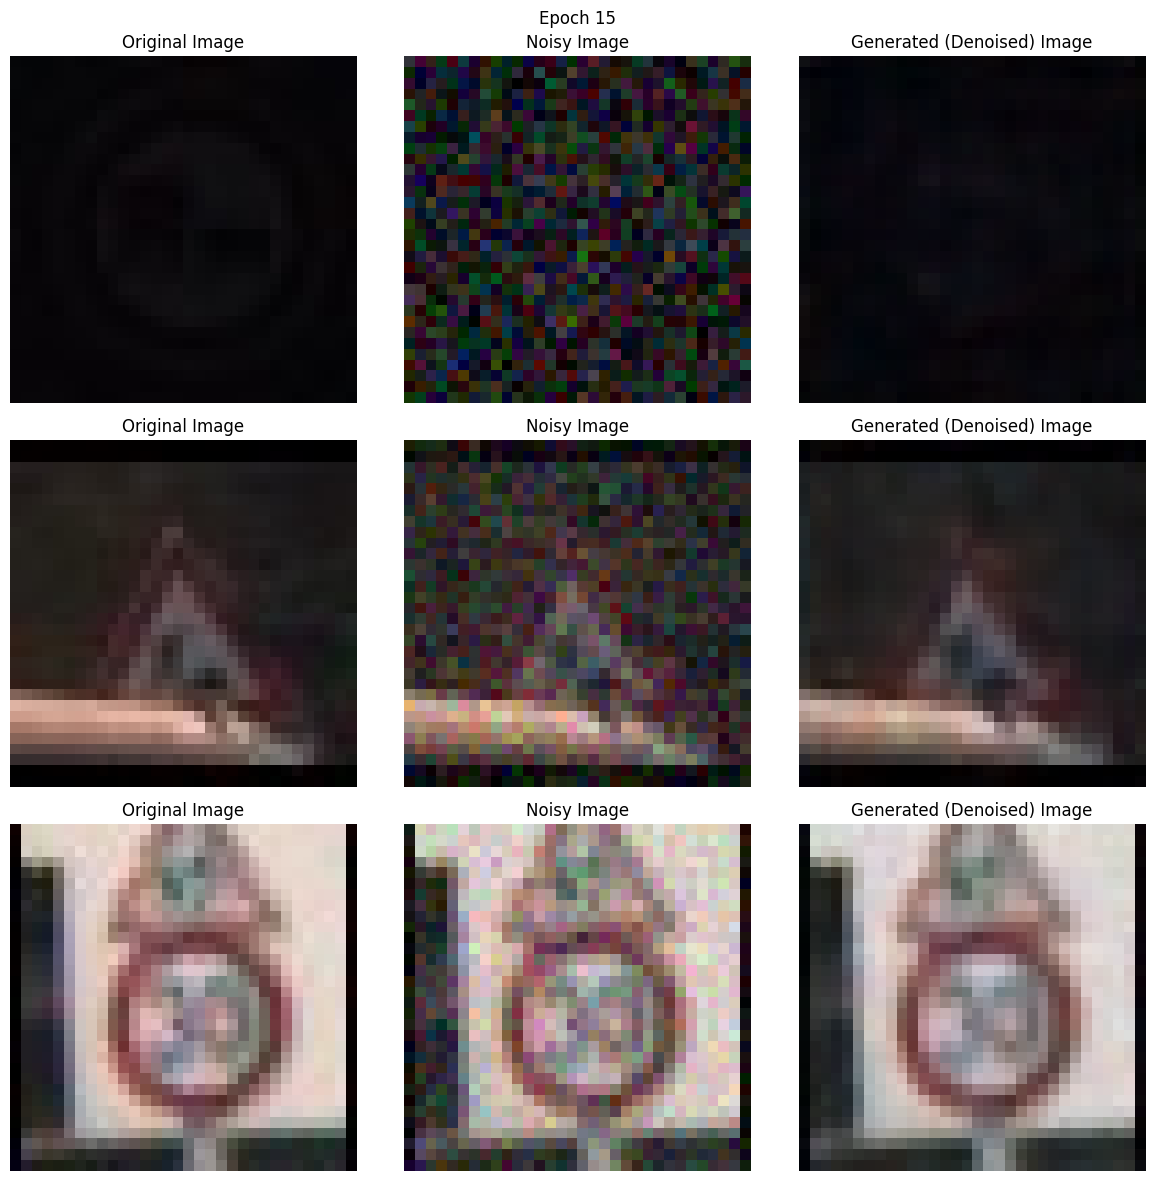

100%|██████████| 613/613 [00:43<00:00, 14.11it/s]


Finished epoch 16. Average loss for this epoch: 0.003251
Sample 1:
Tensor min: -1.0000, max: -0.0275
Tensor min: -1.0000, max: 0.0123
Tensor min: -1.0304, max: -0.0528
Sample 2:
Tensor min: -0.9529, max: -0.6235
Tensor min: -1.0000, max: -0.2757
Tensor min: -0.9308, max: -0.5648
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.1395, max: 1.0971


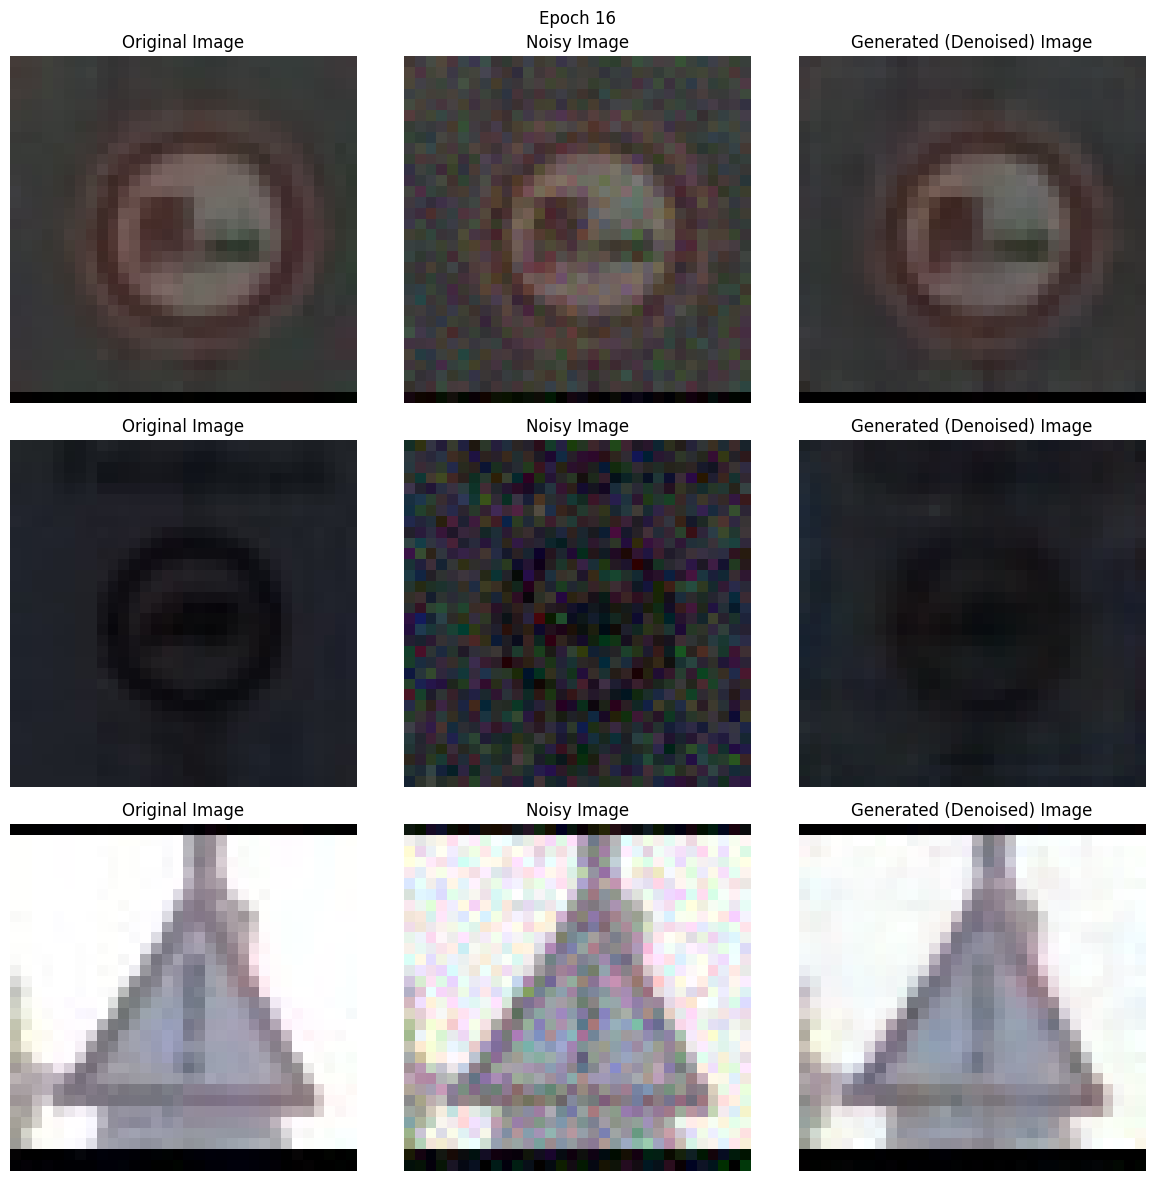

100%|██████████| 613/613 [00:43<00:00, 13.99it/s]


Finished epoch 17. Average loss for this epoch: 0.003225
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.9884, max: 1.0820
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0535, max: 1.0433
Sample 3:
Tensor min: -1.0000, max: 0.1529
Tensor min: -1.0000, max: 0.5334
Tensor min: -1.0231, max: 0.2897


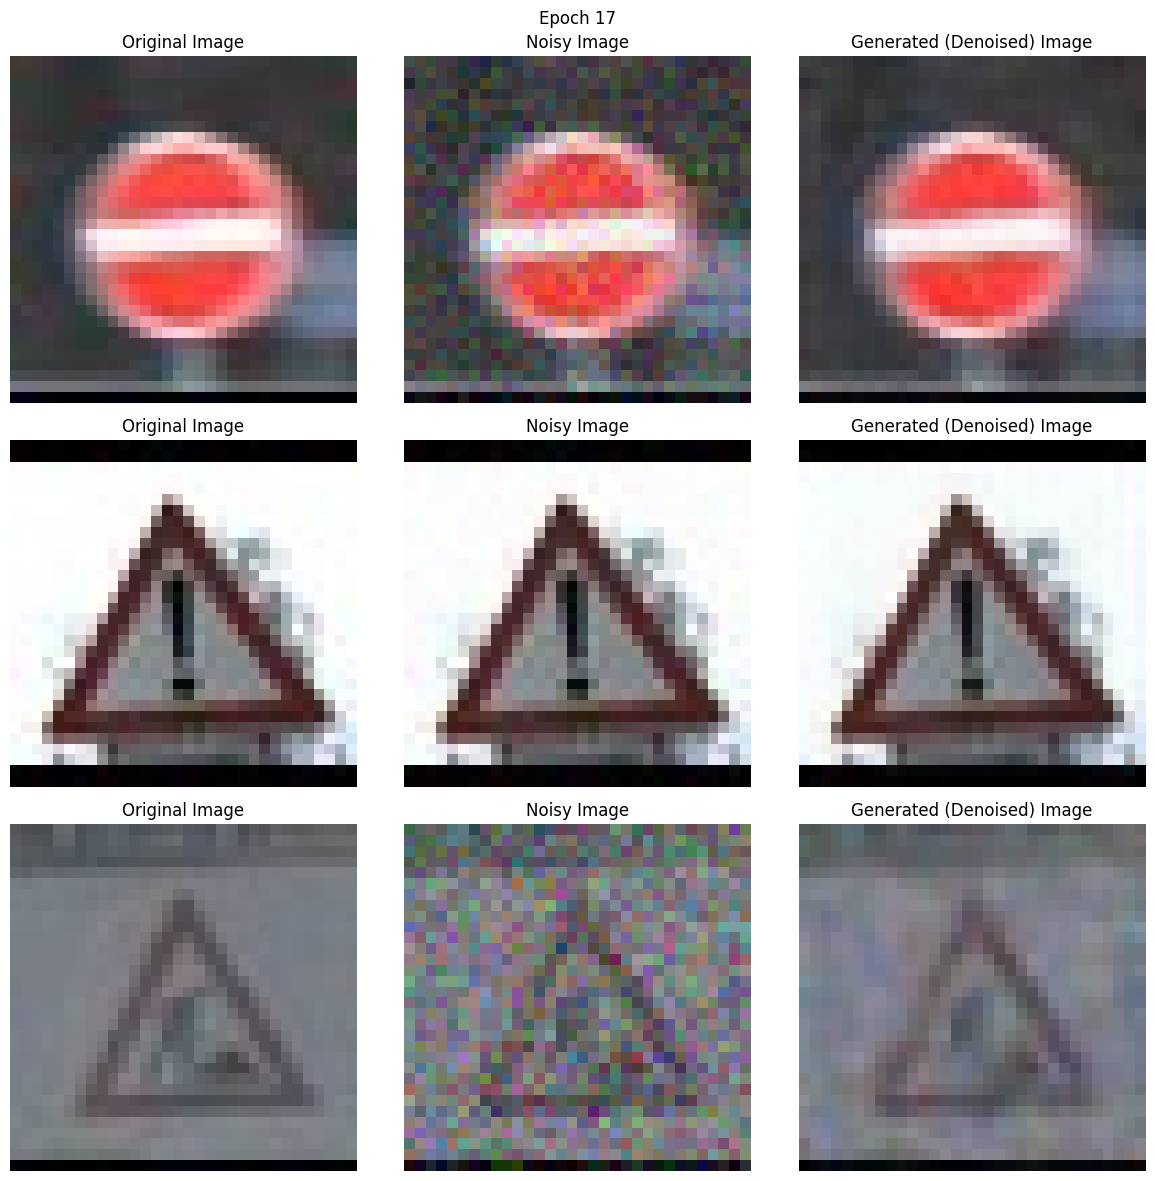

100%|██████████| 613/613 [00:44<00:00, 13.93it/s]


Finished epoch 18. Average loss for this epoch: 0.003199
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0358, max: 1.0167
Sample 2:
Tensor min: -1.0000, max: 0.5686
Tensor min: -1.0000, max: 0.6332
Tensor min: -1.0254, max: 0.5738
Sample 3:
Tensor min: -1.0000, max: 0.2549
Tensor min: -1.0000, max: 0.5692
Tensor min: -1.0712, max: 0.2806


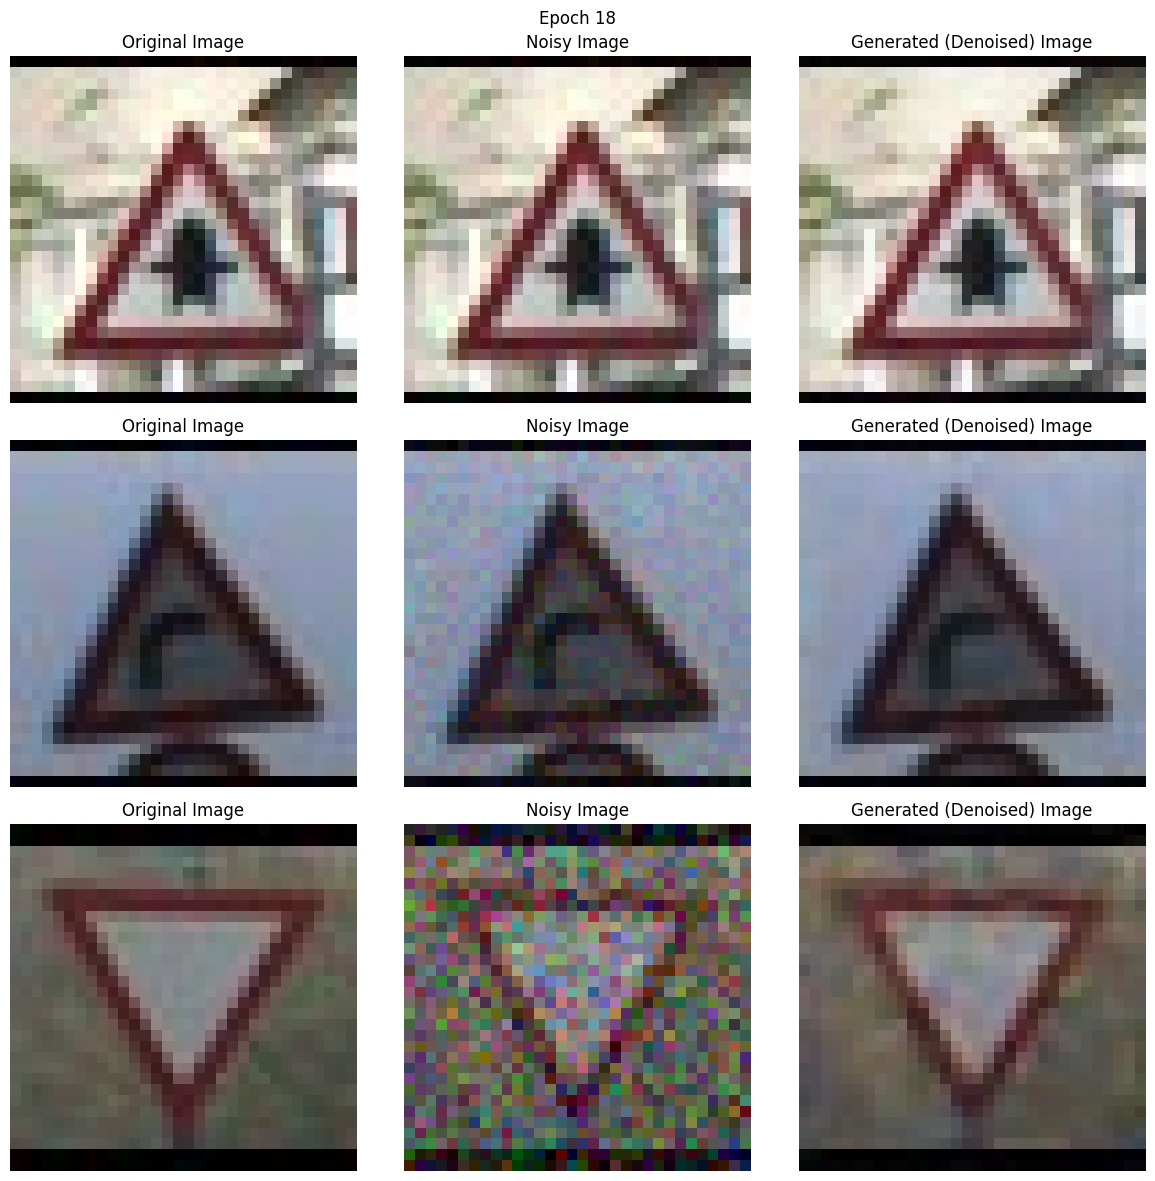

100%|██████████| 613/613 [00:43<00:00, 13.97it/s]


Finished epoch 19. Average loss for this epoch: 0.003087
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0739, max: 1.0919
Sample 2:
Tensor min: -0.8902, max: 0.3098
Tensor min: -1.0000, max: 0.7327
Tensor min: -0.8833, max: 0.4048
Sample 3:
Tensor min: -1.0000, max: 0.2941
Tensor min: -1.0000, max: 0.2422
Tensor min: -0.9600, max: 0.2681


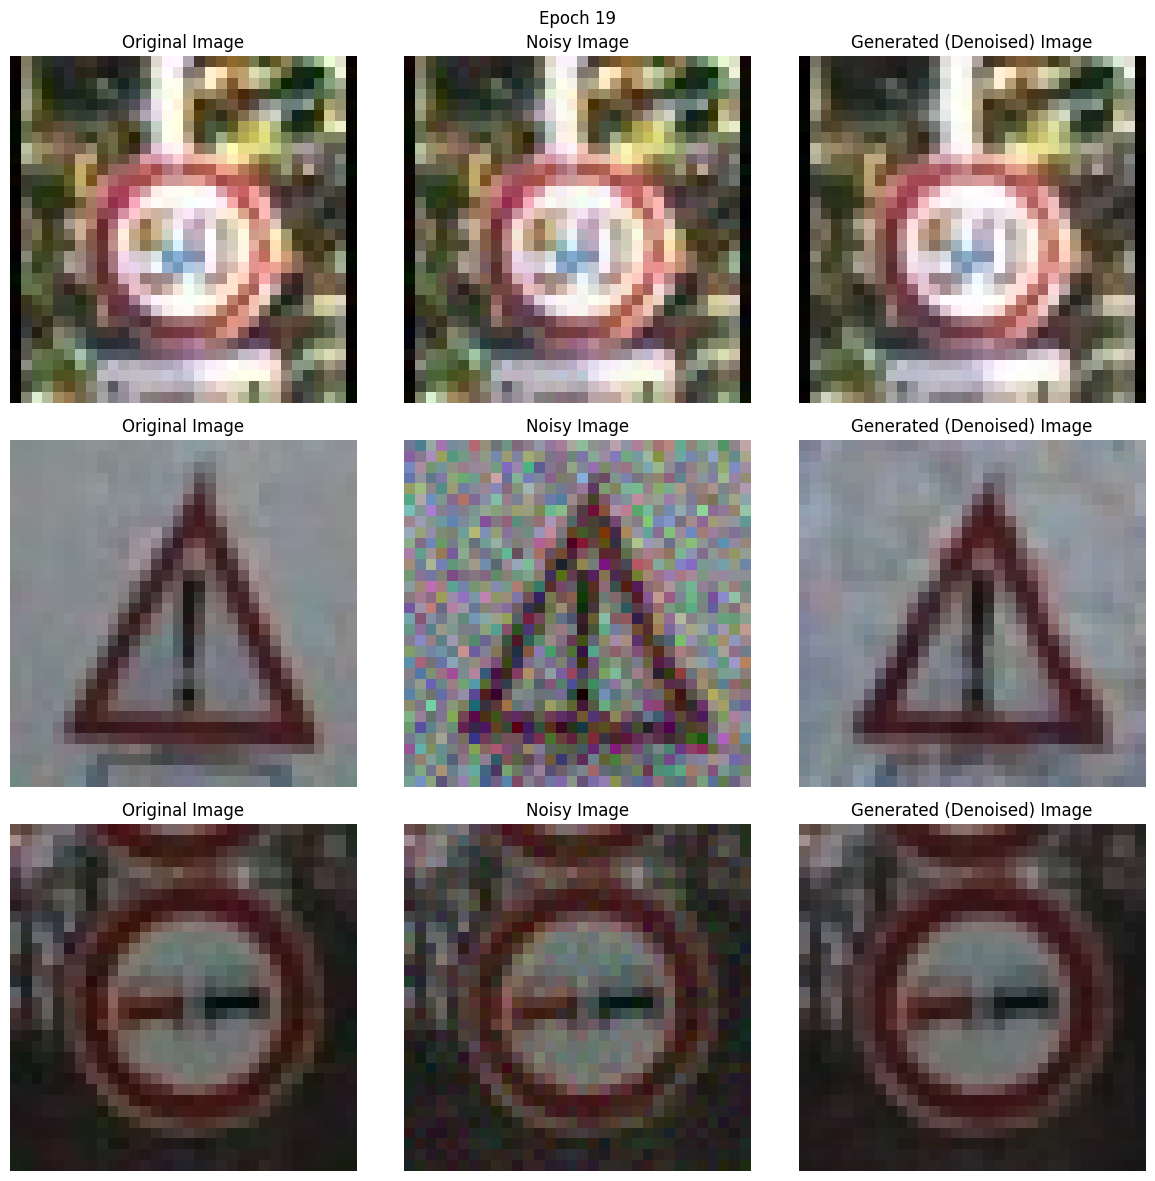

In [47]:
n_epochs = 20

#net = BasicUNet()
#net.to(device)

net = UNet32()
net.to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-4)

losses = []

for epoch in range(n_epochs):

    for x, y in tqdm(loader):
        # y = y.float()
        x = x.to(device)
        y = y.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device) * 0.2

        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x, noise_amount, y)

        loss = loss_fn(pred, x)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(loader):])/len(loader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

    with torch.no_grad():
        num_samples = min(3, x.shape[0])  # Visualize up to 3 images
        fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
        if num_samples == 1:
            axes = [axes]  # Make axes iterable for single sample

        for i in range(num_samples):
            original = x[i]  # Original image
            noisy = noisy_x[i]  # Noisy image
            generated = pred[i]  # Model's denoised output

            # Convert tensors to images
            print(f"Sample {i+1}:")
            original_img = tensor_to_image(original, normalize=True)
            noisy_img = tensor_to_image(noisy, normalize=True)
            generated_img = tensor_to_image(generated, normalize=True)

            # Plot original
            axes[i][0].imshow(original_img)
            axes[i][0].set_title('Original Image')
            axes[i][0].axis('off')

            # Plot noisy
            axes[i][1].imshow(noisy_img)
            axes[i][1].set_title('Noisy Image')
            axes[i][1].axis('off')

            # Plot generated
            axes[i][2].imshow(generated_img)
            axes[i][2].set_title('Generated (Denoised) Image')
            axes[i][2].axis('off')

        plt.suptitle(f'Epoch {epoch}')
        plt.tight_layout()
        plt.show()

plt.plot(losses)
plt.ylim(0, 0.5);

Sample 1:
Tensor min: -3.3409, max: 3.9790
Tensor min: -1.2570, max: 0.6424
Sample 2:
Tensor min: -4.1427, max: 3.2701
Tensor min: -1.1683, max: 0.5498
Sample 3:
Tensor min: -3.4467, max: 3.8744
Tensor min: -1.0952, max: 0.7767
Sample 4:
Tensor min: -3.8327, max: 3.9462
Tensor min: -1.2226, max: 0.7341
Sample 5:
Tensor min: -3.4001, max: 3.2392
Tensor min: -1.1142, max: 0.5751
Sample 6:
Tensor min: -4.1377, max: 3.3785
Tensor min: -1.2376, max: 0.6003
Sample 7:
Tensor min: -3.2711, max: 3.4101
Tensor min: -1.1741, max: 0.7745
Sample 8:
Tensor min: -4.2443, max: 3.5041
Tensor min: -1.2784, max: 0.6813
Sample 9:
Tensor min: -3.8587, max: 3.6916
Tensor min: -1.1198, max: 0.6135
Sample 10:
Tensor min: -3.6605, max: 3.9456
Tensor min: -1.0912, max: 0.6706
Sample 11:
Tensor min: -4.6783, max: 3.3359
Tensor min: -1.1692, max: 0.7234
Sample 12:
Tensor min: -3.5974, max: 3.4645
Tensor min: -1.1751, max: 0.7782
Sample 13:
Tensor min: -3.4532, max: 3.5570
Tensor min: -1.1559, max: 0.7389
Sample 1

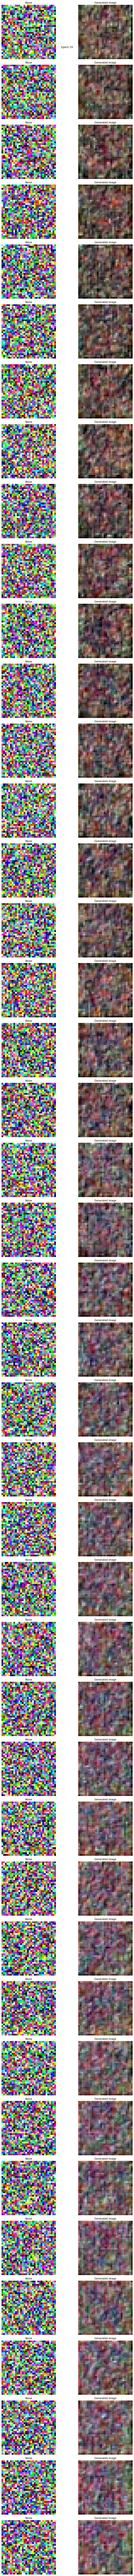

In [62]:
net.eval()
noise_level = 0.2
classes = range(43)
pics = []
noises = []
for c in classes:
    noise = torch.randn(1, 3, 32, 32)
    noise_level_tensor = torch.tensor([noise_level])
    class_tensor = torch.tensor([c])

    noise = noise.to(device)
    noise_level_tensor = noise_level_tensor.to(device)
    class_tensor = class_tensor.to(device)

    new_pic = net(noise, noise_level_tensor, class_tensor)
    pics.append(torch.squeeze(new_pic))
    noises.append(torch.squeeze(noise))

fig, axes = plt.subplots(43, 2, figsize=(12, 4 * 43))

for i in classes:
    # original = x[i]  # Original image
    noisy = noises[i]  # Noisy image
    generated = pics[i]  # Model's denoised output

    # Convert tensors to images
    print(f"Sample {i+1}:")
    # original_img = tensor_to_image(original, normalize=True)
    noisy_img = tensor_to_image(noisy, normalize=True)
    generated_img = tensor_to_image(generated, normalize=True)

    # Plot noise
    axes[i][0].imshow(noisy_img)
    axes[i][0].set_title('Noise')
    axes[i][0].axis('off')

    # Plot generated
    axes[i][1].imshow(generated_img)
    axes[i][1].set_title('Generated image')
    axes[i][1].axis('off')

    # Plot generated
    # axes[i][2].imshow(generated_img)
    # axes[i][2].set_title('Generated (Denoised) Image')
    # axes[i][2].axis('off')

plt.suptitle(f'Epoch {epoch}')
plt.tight_layout()
plt.show()


In [100]:
def p_sample(model, x_t, t, betas):
    alpha_t = 1.0 - betas[t]
    alpha_bar_t = torch.prod(1.0 - betas[:t+1])
    sigma_t = torch.sqrt(betas[t])  # lub bardziej zaawansowana wersja

    y = torch.Tensor([0]).to(device)
    t = torch.Tensor([t]).to(device)
    # print(f"{y.shape}")

    eps_theta = model(x_t, t, y)  # model predykcji szumu

    mean = (1 / torch.sqrt(alpha_t)) * (x_t - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * eps_theta)

    if t > 0:
        z = torch.randn_like(x_t)
        return mean + sigma_t * z
    else:
        return mean  # ostatni krok: bez dodatkowego szumu


In [81]:
def q_sample(x_0, t, sqrt_alpha_cumprod, sqrt_one_minus_alpha_cumprod):
    # Dodaje szum zgodnie z t
    noise = torch.randn_like(x_0)
    # print(f"{sqrt_alpha_cumprod.shape}")
    # print(f"{sqrt_alpha_cumprod[t].view(-1, 1, 1, 1).shape}; {x_0.shape}; {sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1).shape}; {noise.shape}")
    return (
        sqrt_alpha_cumprod[t].view(-1, 1, 1, 1) * x_0 + sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1) * noise,
        noise  # jako ground truth
    )

In [67]:
num_timesteps = 1000
betas = torch.linspace(1e-4, 0.02, num_timesteps)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

In [80]:
print(f"{torch.sqrt(alphas_cumprod).shape=}")
sqrt_alpha_cumprod = torch.sqrt(alphas_cumprod).to(device)
sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - alphas_cumprod).to(device)

torch.sqrt(alphas_cumprod).shape=torch.Size([1000])


In [85]:
n_epochs = 20

#net = BasicUNet()
#net.to(device)

net2 = UNet32()
net2.to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-4)

losses = []

noise_step = 0.02
net2.train()

for epoch in range(n_epochs):

    for x, y in tqdm(loader):
        # y = y.float()
        x = x.to(device)
        y = y.to(device)
        t = torch.randint(0, num_timesteps, (x.shape[0],), device=device)

        x_t, noise = q_sample(x, t, sqrt_alpha_cumprod, sqrt_one_minus_alpha_cumprod)

        pred = net2(x_t, t, y)

        loss = loss_fn(pred, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(loader):])/len(loader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

    # with torch.no_grad():
    #     num_samples = min(3, x.shape[0])  # Visualize up to 3 images
    #     fig, axes = plt.subplots(num_samples, 4, figsize=(12, 4 * num_samples))
    #     if num_samples == 1:
    #         axes = [axes]  # Make axes iterable for single sample

    #     for i in range(num_samples):
    #         original = x[i]  # Original image
    #         noisy = noisy_x[i]  # Noisy image t
    #         generated = pred[i]  # Model's denoised output

    #         # Convert tensors to images
    #         print(f"Sample {i+1}:")
    #         original_img = tensor_to_image(original, normalize=True)
    #         noisy_img = tensor_to_image(noisy, normalize=True)
    #         noisy2_img = tensor_to_image(noisy2, normalize=True)
    #         generated_img = tensor_to_image(generated, normalize=True)

    #         # Plot original
    #         axes[i][0].imshow(original_img)
    #         axes[i][0].set_title('Original Image')
    #         axes[i][0].axis('off')

    #         # Plot noisy t
    #         axes[i][1].imshow(noisy_img)
    #         axes[i][1].set_title('Noisy t Image')
    #         axes[i][1].axis('off')

    #         # Plot generated
    #         axes[i][2].imshow(generated_img)
    #         axes[i][2].set_title('Generated (Denoised) Image')
    #         axes[i][2].axis('off')

    #     plt.suptitle(f'Epoch {epoch}')
    #     plt.tight_layout()
    #     plt.show()

100%|██████████| 613/613 [00:46<00:00, 13.14it/s]


Finished epoch 0. Average loss for this epoch: 1.138158


100%|██████████| 613/613 [00:45<00:00, 13.40it/s]


Finished epoch 1. Average loss for this epoch: 1.138370


100%|██████████| 613/613 [00:44<00:00, 13.74it/s]


Finished epoch 2. Average loss for this epoch: 1.138005


100%|██████████| 613/613 [00:45<00:00, 13.46it/s]


Finished epoch 3. Average loss for this epoch: 1.138023


100%|██████████| 613/613 [00:44<00:00, 13.86it/s]


Finished epoch 4. Average loss for this epoch: 1.138374


100%|██████████| 613/613 [00:44<00:00, 13.75it/s]


Finished epoch 5. Average loss for this epoch: 1.138363


100%|██████████| 613/613 [00:44<00:00, 13.66it/s]


Finished epoch 6. Average loss for this epoch: 1.137822


100%|██████████| 613/613 [00:43<00:00, 14.19it/s]


Finished epoch 7. Average loss for this epoch: 1.138184


100%|██████████| 613/613 [00:42<00:00, 14.40it/s]


Finished epoch 8. Average loss for this epoch: 1.137888


100%|██████████| 613/613 [00:44<00:00, 13.89it/s]


Finished epoch 9. Average loss for this epoch: 1.138213


100%|██████████| 613/613 [00:45<00:00, 13.57it/s]


Finished epoch 10. Average loss for this epoch: 1.137938


100%|██████████| 613/613 [00:45<00:00, 13.47it/s]


Finished epoch 11. Average loss for this epoch: 1.138016


100%|██████████| 613/613 [00:45<00:00, 13.56it/s]


Finished epoch 12. Average loss for this epoch: 1.137858


100%|██████████| 613/613 [00:44<00:00, 13.86it/s]


Finished epoch 13. Average loss for this epoch: 1.138365


100%|██████████| 613/613 [00:44<00:00, 13.72it/s]


Finished epoch 14. Average loss for this epoch: 1.138199


100%|██████████| 613/613 [00:44<00:00, 13.92it/s]


Finished epoch 15. Average loss for this epoch: 1.137423


100%|██████████| 613/613 [00:44<00:00, 13.74it/s]


Finished epoch 16. Average loss for this epoch: 1.138408


100%|██████████| 613/613 [00:45<00:00, 13.50it/s]


Finished epoch 17. Average loss for this epoch: 1.138086


100%|██████████| 613/613 [00:43<00:00, 13.97it/s]


Finished epoch 18. Average loss for this epoch: 1.138567


100%|██████████| 613/613 [00:43<00:00, 14.19it/s]

Finished epoch 19. Average loss for this epoch: 1.138066


Tensor min: -3.7736, max: 3.2443
Tensor min: -3.8109, max: 3.4156
Tensor min: -3.9290, max: 3.5660
Tensor min: -4.2550, max: 3.6767
Tensor min: -4.5342, max: 3.7680
Tensor min: -4.5591, max: 3.7897
Tensor min: -4.2988, max: 3.9847
Tensor min: -4.3251, max: 4.1164
Tensor min: -4.4350, max: 4.2019
Tensor min: -4.4765, max: 4.3332
Tensor min: -4.4393, max: 4.2519
Tensor min: -4.3258, max: 4.2784
Tensor min: -4.3497, max: 4.5896
Tensor min: -4.5197, max: 4.7793
Tensor min: -4.5680, max: 4.9563
Tensor min: -4.7563, max: 4.9483
Tensor min: -5.0296, max: 5.1465
Tensor min: -5.1700, max: 5.2870
Tensor min: -5.1063, max: 5.1220
Tensor min: -5.0003, max: 5.1515
Tensor min: -5.0669, max: 5.3784
Tensor min: -4.9120, max: 5.4974
Tensor min: -4.8344, max: 5.8230
Tensor min: -4.8286, max: 5.8558
Tensor min: -5.1184, max: 6.0384
Tensor min: -5.3217, max: 6.0106
Tensor min: -5.4347, max: 6.2128
Tensor min: -5.5061, max: 6.2045
Tensor min: -5.4211, max: 6.4069
Tensor min: -5.3483, max: 6.6683
Tensor min

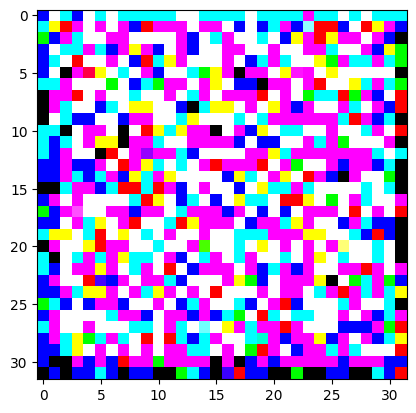

In [110]:
net2.eval()

x_t = torch.randn((1, 3, 32, 32)).to(device)
T = 1000
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

for t in reversed(range(T)):
    x_t = p_sample(net2, x_t, t, betas)
    plt.imshow(tensor_to_image(torch.squeeze(x_t)))